# Notebook 1: UK data template 

In [1]:
# This notebook combines text cleaning, preprocessing, topic modeling, user profile topic vectors creation as well as topic aggregation 

In [1]:
#importing essential libraries 
import pandas as pd
import numpy as np
import glob
import requests
import json
import tldextract
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import re
import nltk
from nltk.corpus import stopwords
from gensim.models import CoherenceModel
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
import gensim
from gensim import corpora, models
nltk.download('stopwords')
SOME_FIXED_SEED = 42
np.random.seed(SOME_FIXED_SEED)

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/meftahzi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# data-source contains the csv files of either us or uk data
data_source = 'merged-parsed-tracking_uk.csv'
# importing the data
data = pd.read_csv(data_source, sep=';')
data.reset_index(inplace=True, drop=True)
print("The inital number of records is: " + str(len(data)))

/home/meftahzi/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (2,4,7,9,21) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


The inital number of records is: 676495


In [3]:
data.drop(['app_name', 'app_package_name', 'used_at', 'device_os', 'device_type', 'connection','error', 'check', 'panel', 'movies'], axis = 1, inplace = True)
data= data[data["duration"] != r"\N"]
data["duration"] = pd.to_numeric(data["duration"], downcast="float")

# 1. Data wrangling

The purpose of our data wrangling pipeline is to create a tidy data which can be used
for analysis. This part of the thesis was the most challenging as the provided data
included a lot of texts that are not news articles and there is no automated way of
detecting them. We had to go through several steps and build multiple models to
reach the desirable clean data

## 1.1. English articles

> We want to keep only the articles written in english. For that, We combine <b>"fasttext"</b> library result and filter on <b>"meta_lang"</b> column.

In [4]:
# First, We get rid of empty rows.
data=data[data['title'].notnull() & data['text'].notnull()]
print("The remaining number of records is: " + str(len(data)))

The remaining number of records is: 597499


In [5]:
 #select only articles with 'en' meta_lang or with empty
data= data[(data['meta_lang'] == 'en') | (data['meta_lang'].isnull())] 
print("The remaining number of records is: " + str(len(data)))

The remaining number of records is: 593479


In [ ]:
# We opted for fasttext python library that is built on a pre-trained model “lid.176.bin” since it was the fastest and the most accurate in language detection

In [6]:
import fasttext

PRETRAINED_MODEL_PATH = '/home/meftahzi/Task_Narges/lid.176.bin'
model = fasttext.load_model(PRETRAINED_MODEL_PATH)

In [7]:
data = data.replace('\n','', regex=True)
temp = model.predict(list(data["text"]))[0]
data["lang"] = temp

data["lang"] = data["lang"].astype(str)
data["lang"] = data["lang"].apply(lambda lang: lang[11:-2])
data["lang"].value_counts()

en     590872
it       2329
fr        144
ca         36
gd         21
es         16
pl         15
de          8
my          8
cy          7
uk          6
hu          3
ru          3
he          3
ga          3
pt          2
ceb         2
ja          1
Name: lang, dtype: int64

In [8]:
from pycountry import languages
# this is used for getting the full language name instead of its abbreviation 
def full_lang(lang):
    try: 
        return(languages.get(alpha_2=lang).name)
    except: 
        pass
                                  
data["lang"] = data["lang"].apply(lambda lang: full_lang(lang))

In [9]:
# We keep english records only
data=data[data["lang"]=="English"]
print("The remaining number of records is: " + str(len(data)))

The remaining number of records is: 590872


## 1.2. Domain filtering

> This part is mainly for <b>UK data</b> : <br> 
Using <b>"tldextract"</b> library, we can split our URLs into <b>domains</b>,<b>subdomains</b>, and <b>suffixes</b>.<br> It is used for the purpose of filtering out the irrelevant subdomains, and suffixes. 

In [13]:
import tldextract
data['domain'] = data['url'].apply (lambda row: tldextract.extract(row).domain + "." + tldextract.extract(row).suffix)
data['subdomain'] = data['url'].apply (lambda row: tldextract.extract(row).subdomain)
data['suffix'] = data['url'].apply (lambda row: tldextract.extract(row).suffix)

3647.358024691358


Text(3, 170000, 'This side covers 93.67% of the whole UK data')

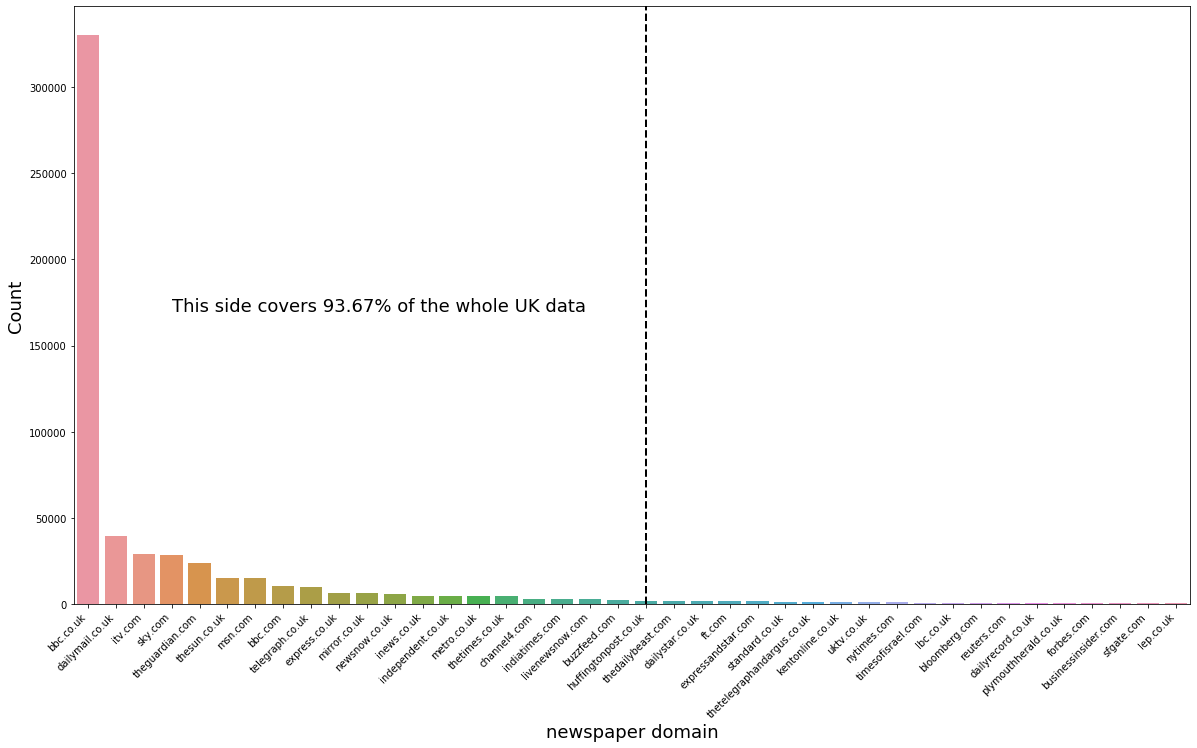

In [14]:
# Dataframe representing all the domains and their respective occurence)  
domains_by_count = pd.DataFrame({"domain":data.domain.value_counts().index, "occurrence":data.domain.value_counts().values, "fraction": data.domain.value_counts().values/data.domain.value_counts().values.sum()})
domains_by_count.head(50)
import seaborn 
plt.figure(figsize=(20,11)) 
ax=seaborn.barplot(x=domains_by_count['domain'].head(40), y=domains_by_count['occurrence'].head(40))
plt.xlabel('newspaper domain',fontsize=18)
plt.ylabel('Count',fontsize=18)
print(domains_by_count['occurrence'].mean())
plt.axvline(20, color='k', linestyle='dashed', linewidth=2)
plt.xticks(rotation=45,ha='right')
plt.annotate('This side covers '+str(round(domains_by_count['occurrence'].head(20).sum()/domains_by_count['occurrence'].sum()*100, 2))+ "% of the whole UK data" , xy=(10, 30), xytext=(3, 170000), fontsize=18)

In [15]:
print('The number of unique domains and subdomains:')
data.agg({"domain": "nunique","subdomain": "nunique"})

The number of unique domains and subdomains:


domain       162
subdomain    362
dtype: int64

In [16]:
k = 19
k_top = domains_by_count.head(k)
print(f"The top {k+1} domains cover "+str(k_top['fraction'].sum())+ " of the whole dataset")
print(k_top['occurrence'].sum())

The top 20 domains cover 0.9324676071974981 of the whole dataset
550969


In [17]:
# Example
data[data['domain']=="bbc.co.uk"]["subdomain"].value_counts()

www                          258365
                              69770
polling                         904
news                            420
open.live                       207
ssl                             150
careershub                      125
careerssearch                    26
search                           19
downloads-app.iplayer.api        15
genome.ch                        14
m                                10
session                           8
bbcsignups.external               6
ssl.live                          6
www.test                          3
wscdn                             2
beta                              1
Name: subdomain, dtype: int64

> We consider the top 20 UK domains and keep only their relevant subdomains and tags. <br>
Check table  : https://docs.google.com/document/d/1ZumFo_s8Urrl0H9sAx245fDHfmyA_tyaWQlnoqE_nqI/edit?usp=sharing 

In [19]:
# Here, we have a list of domains with their relevant subdomains and tags.
relevant_domains= ["bbc.co.uk/news/",
"Ablink.editorial.theguardian.com",
"theguardian.com/news/",
"theguardian.com/world/",
"theguardian.com/commentisfree/",
"theguardian.com/us-news/",
"theguardian.com/uk-news/",
"theguardian.com/politics/",
"theguardian.com/education/",
"theguardian.com/society/",
"theguardian.com/science/",
"theguardian.com/business/",
"theguardian.com/money/",
"theguardian.com/sport/",
"theguardian.com/australia-news/",
"theguardian.com/travel/",
"theguardian.com/technology/",
"theguardian.com/commentisfree/",
"dailymail.co.uk/news/",
"dailymail.co.uk/columnists/",
"dailymail.co.uk/debate/",
"dailymail.co.uk/femail/",
"dailymail.co.uk/health/",
"dailymail.co.uk/money/",
"dailymail.co.uk/sport/",
"dailymail.co.uk/travel/",
"dailymail.co.uk/tvshowbiz/",
"news.sky.com/story/",
"thesun.co.uk/fabulous/",
"thesun.co.uk/money/",
"thesun.co.uk/news/",
"thesun.co.uk/sport/",
"thesun.co.uk/travel/",
"thesun.co.uk/tech/",
"www.telegraph.co.uk/politics/",
"www.telegraph.co.uk/news/",
"express.co.uk",
"metro.co.uk",
"itv.com/news",
"independent.co.uk/news",
"thetimes.co.uk/article",
"www.channel4.com/news",
"inews.co.uk/news",
"thetelegraphandargus.co.uk/news",
"nytimes.com/20",
"standard.co.uk/news",
"kentonline.co.uk",
"ft.com/content",
"eveningtimes.co.uk/news",
"eveningtimes.co.uk/content"]

In [20]:
data=data[data.url.str.contains('|'.join(relevant_domains))]
data=data[data["url"].str.contains("express.co.uk/showbiz|discountcode.metro.co.uk|Link.news.metro.co.uk|www.metro.co.uk|api.metro.co.uk")==False]

print("The remaining number of records is: " + str(len(data)))

The remaining number of records is: 141676


## 1.3 URL filtering 

> The idea here is to get rid of main pages of different newspapers.<br>
These pages were recrawled many times which means the content shown has changed from the one the user saw the first time.

In [500]:
# The function below parses the URL string and checks different conditions on the suffix for it to be a main webpage. 
# It is based on our observation of the structure of URLs in our dataset

In [21]:
def check_url(url):
    #returns true if mainpage and false otherwise
    check = url.split("/")[1:]
    
    if "index.html" in url :
        return(True)
    elif (url[-1] == "/"):
        if len(check) <= 1 :
            return(True)
        elif (len(check[-2])< 15) and (check[-2].isnumeric() == False)  :
            return(True)
    elif len(check) == 0 :
        return(True)
    elif (len(check[-1])< 15) and (check[-1].isnumeric() == False) and ("?" not in url) and ("html" not in url):
        return(True)
    else : 
        return(False) 

In [22]:
data['check_url'] = data['url'].apply (lambda row: check_url(row))

In [23]:
def find_between( s, first, last ):
    try:
        start = s.index( first ) + len( first )
        end = s.index( last, start )
        if len(s[start:end])<30:
            return s[start:end]
        else : 
            return ""
    except ValueError:
        return ""

In [24]:
data['meta_keywords_first'] = data['meta_keywords'].apply (lambda row: find_between( row, "[", "," ))

In [25]:
data['meta_keywords_first'].value_counts().rename_axis('meta_keywords').reset_index(name='counts').head(20)

meta_keywords  counts
0                    108155
1       'dailymail'   13686
2   'Jose Mourinho'    1482
3            'News'    1253
4       'clockword'    1170
5        'Politics'    1070
6          'Brexit'    1036
7            'news'     809
8     'Theresa May'     409
9         'Chelsea'     278
10   'Donald Trump'     267
11          'Crime'     171
12    'US politics'     170
13       'Business'     163
14        'showbiz'     152
15  'Meghan Markle'     138
16  'Conservatives'     113
17   'Nigel Farage'     109
18         'Labour'     104
19        'Handbag'      98

In [26]:
data['url_counts'] = data['url'].map(data['url'].value_counts())
data['duration_counts'] = data['duration'].map(data['duration'].value_counts())
data['imgs_counts'] = data['imgs'].map(data['imgs'].value_counts())
data['text_counts'] = data['text'].map(data['text'].value_counts())
data['title_counts'] = data['title'].map(data['title'].value_counts())
data['check_url']= data['url'].apply(lambda url: check_url(url))

In [27]:
#example of URLs deleted
data[data['check_url']==True]["url"].value_counts().head(10)

bbc.co.uk/news/uk                                  2891
www.bbc.co.uk/news/business                        2553
www.bbc.co.uk/news/uk                              2337
www.bbc.co.uk/news/england                         2249
www.bbc.co.uk/news/world                           1726
www.express.co.uk/                                 1689
www.bbc.co.uk/news/business/market-data            1611
www.bbc.co.uk/news/topics/c9qdqqkgz27t/ftse-100    1296
www.dailymail.co.uk/sport/index.html               1178
metro.co.uk/                                       1170
Name: url, dtype: int64

In [28]:
data = data[data['check_url']==False]

In [29]:
data[data['check_url']==False]["url"].value_counts().head(20)

www.bbc.co.uk/news/entertainment_and_arts                                                         1281
bbc.co.uk/news/england/northamptonshire                                                            665
www.bbc.co.uk/news/0                                                                               652
www.bbc.co.uk/news/live/uk-politics-parliaments-47696409                                           573
bbc.co.uk/news/entertainment_and_arts                                                              561
www.bbc.co.uk/news/science_and_environment                                                         455
www.bbc.co.uk/news/topics/clyeyy8851qt/dow-jones-industrial-average                                451
www.bbc.co.uk/news/topics/crjeqkdevwvt/the-uks-european-elections-2019                             445
www.bbc.co.uk/news/live/uk-politics-parliaments-47614151                                           424
www.bbc.co.uk/news/live/uk-politics-47772688                             

In [31]:
print("The remaining number of records is: " + str(len(data)))

The remaining number of records is: 88955


## 1.4. Text filtering 

we took our title column and computed the number of times articles appear in our dataset using exact
string matching. Then, we tried to filter out any records that are not articles by setting
a cut-off threshold.

In [33]:
data['url_counts'] = data['url'].map(data['url'].value_counts())
data['duration_counts'] = data['duration'].map(data['duration'].value_counts())
data['imgs_counts'] = data['imgs'].map(data['imgs'].value_counts())
data['text_counts'] = data['text'].map(data['text'].value_counts())
data['title_counts'] = data['title'].map(data['title'].value_counts())

In [501]:
# the dataframe below shows each article and its number of occurrences between thresholds
# this was used to pick the number of irreleant articles for each threshold. This is stored in text_dic

In [33]:
text_counts = pd.DataFrame(data.text.value_counts())
text_threshold = 0
print(len(text_counts[text_counts['text'].between(text_threshold,max(text_counts['text']))]))
print(text_counts[text_counts['text'].between(text_threshold,max(text_counts['text']))]['text'].sum())

print(text_counts[text_counts['text'].between(text_threshold,text_threshold+9)]['text'].sum())
print(text_counts[text_counts['text'].between(text_threshold,text_threshold+max(text_counts['text']))]['text'].sum())
print(4)

text_counts[text_counts['text'].between(text_threshold,10000000)] .head(20)

27667
88955
55975
88955
4


text
What term do you want to search? Search with go...   751
Make informed decisions with the FTKeep abreast...   464
Gains for The Brexit Party and Lib DemsIt's bee...   461
Getty ImagesWall Street shares have opened lowe...   451
PA Copyright: PADUP deputy leader Nigel Dodds s...   450
Getty Images Copyright: Getty ImagesMPs are goi...   308
Have Your Say                                        292
Chelsea's Champions League 2019/20 group stage ...   260
The projected results for the new European Parl...   219
Voters have delivered a stinging rebuke to the ...   218
So, with results declared up and down the count...   184
LIVE: MPs tell May to avoid no-deal on 12 April...   180
Attenborough ship gets its top decksEngineers a...   171
Hundreds of people may have missed out on votin...   163
With the results for Waverley and Mansfield now...   161
Thomas Cook Thomas Cook's website this morningT...   160
Image copyright ReutersGermany's two biggest le...   158
Getty Images Copyright: Getty ImagesThat's wher...   134
Planting more trees 'could lead to species loss...   132
BBC Copyright: BBCDominic Raab says leadership ...   126

In [502]:
#Compute Data loss as the number of unique relevant articles lost at a certain threshold given the occurrences.
# Compute ideal loss by taking df[0]/df[1]=1 as all unique_articles_lost will be equal to total_lost

    threshold  relevant_lost  total_lost  unique_articles_lost  data_loss  \
0         500              0         751                     1      0.000   
1         400           2281        3032                     6      4.514   
2         300           2281        3340                     7      4.781   
3         200           2978        4329                    11      7.567   
4         190           2978        4329                    11      7.567   
5         180           3342        4693                    13      9.258   
6         170           3342        4864                    14      9.619   
7         160           3826        5348                    17     12.162   
8         150           3984        5506                    18     13.024   
9         140           3984        5506                    18     13.024   
10        130           4250        5772                    20     14.726   
11        120           4376        6265                    24     16.764   

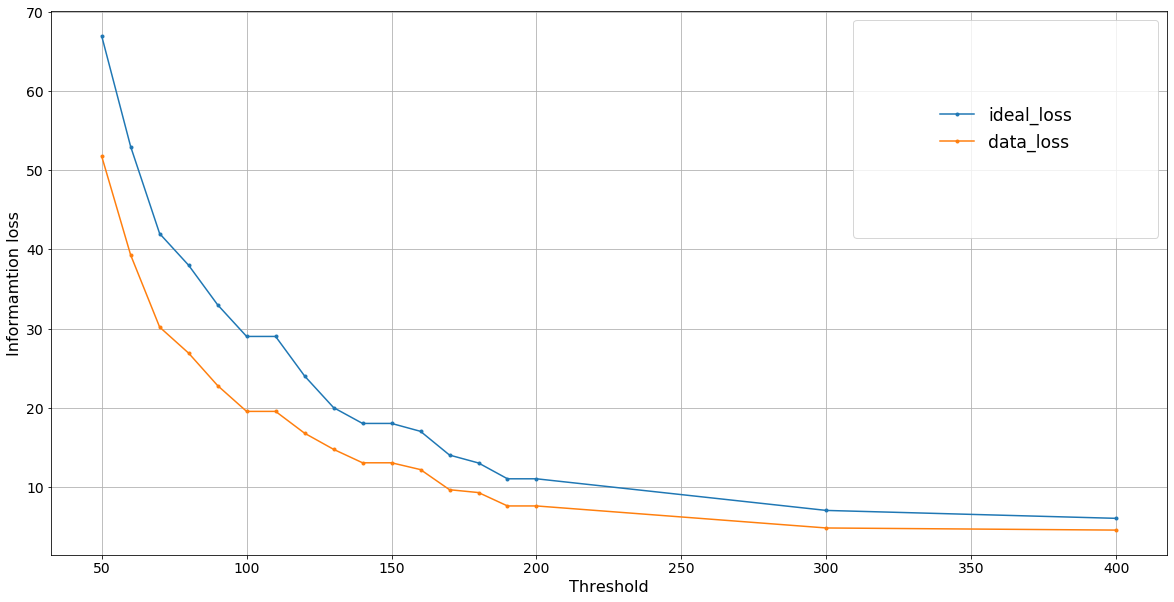

In [162]:
text_dict= {500:[0,751,1], 400:[2281,3032,6], 300:[2281,3340,7], 200:[2978,4329,11], 190:[2978,4329,11], 180:[3342,4693,13], 170:[3342,4864,14],
160:[3826,5348,17], 150:[3984,5506,18], 140:[3984,5506,18], 130:[4250,5772,20],120:[4376,6265,24], 110:[4604,6839,29], 
100: [4604,6839,29],90:[4986,7221,33], 80: [5409,7644,38], 70:[5705,7940,42], 60:[6408,8643,53] , 50:[7270, 9405,67]}

l= text_counts[text_counts['text'].between(50,max(text_counts['text']))]['text'].sum()
z = len(text_counts[text_counts['text'].between(50,max(text_counts['text']))])

df=pd.DataFrame.from_dict(text_dict,orient='index')

df['data_loss']=  round((df[2]) * (df[0]/df[1]), 3)
df = df.reset_index()
df = df.rename(columns={"index":"threshold", 0:"relevant_lost", 1:"total_lost", 2:"unique_articles_lost"})

def my_threshold_funct(x):
    k= int(df[df["threshold"]==x]["total_lost"])
    b= int(df[df["threshold"]==x]["unique_articles_lost"])
    
    y = b
    return y
df

df["ideal_loss"] = df['threshold'].apply(lambda row: my_threshold_funct(row) )
               
df.sort_values(by=['threshold'])
print(df)

ax1 = df.drop([0], axis=0).plot(x='threshold', y=["ideal_loss","data_loss"],figsize=(20, 10), grid=True,style='.-')
ax1.set_ylabel('Informamtion loss',fontdict={'fontsize':16})
ax1.set_xlabel('Threshold',fontdict={'fontsize':16})
plt.xticks(fontsize = 14 )
plt.yticks(fontsize = 14 )
plt.legend(loc='upper right',borderpad=5, fontsize= 'xx-large')


In [149]:
df

threshold  relevant_lost  total_lost  unique_articles_lost  \
0         500              0         751                     1   
1         400            450        3032                     6   
2         300            450        3340                     7   
3         200            987        4329                    11   
4         190           2089        4329                    11   
5         180           3342        4693                    13   
6         170           3342        4864                    14   
7         160           3826        5348                    17   
8         150           3984        5506                    18   
9         140           3984        5506                    18   
10        130           4250        5772                    20   
11        120           4376        6265                    24   
12        110           4604        6839                    29   
13        100           4604        6839                    29   
14         90           4986        7221                    33   
15         80           5409        7644                    38   
16         70           5705        7940                    42   
17         60           6408        8643                    53   
18         50           7270        9405                    67   

    information_loss  
0           0.000000  
1           0.505874  
2           0.505874  
3           1.109550  
4           2.348378  
5           3.756956  
6           3.756956  
7           4.301051  
8           4.478669  
9           4.478669  
10          4.777697  
11          4.919341  
12          5.175651  
13          5.175651  
14          5.605081  
15          6.080603  
16          6.413355  
17          7.203642  
18          8.172672

In [163]:
# Take the minimum distance as it is the minimum data loss across all
thresholds
import math
distances = []
def distance(x,y):
    k= int(df[df["threshold"]==x]["total_lost"])
    b= int(df[df["threshold"]==x]["unique_articles_lost"])
    return abs((y - b)/(501 - x  ) )

threshold = list(df["threshold"])
fraction= list(df["data_loss"])
for i in range(len(df)):
    count= round(distance(threshold[i],fraction[i]),4)
    distances.append(count)
    
df["distance"]= distances
df["distance"][0] = "-" 

/home/meftahzi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/home/meftahzi/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


Text(0.5, 0, 'Threshold of text filtering for the US dataset')

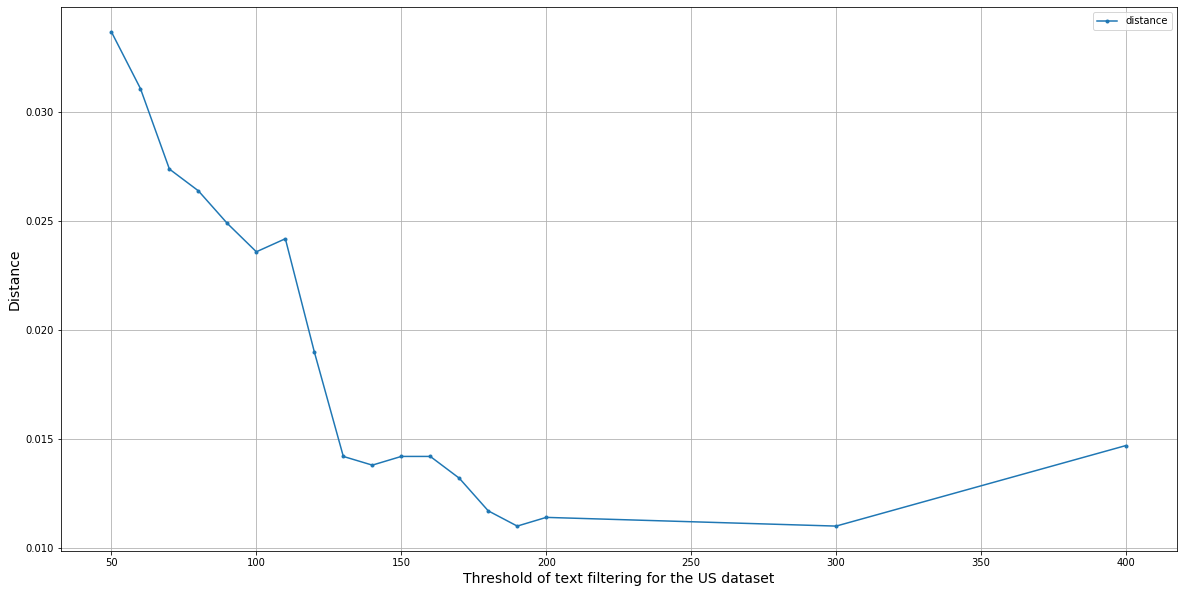

In [164]:
ax1 = df.drop([0], axis=0).plot(x='threshold', y=["distance"],figsize=(20, 10), grid=True,style='.-')
ax1.set_ylabel('Distance',fontdict={'fontsize':14})
ax1.set_xlabel('Threshold of text filtering for the US dataset',fontdict={'fontsize':14})

In [36]:
data = data[data['text_counts'] <= 190]
print("The remaining number of records is: " + str(len(data)))

The remaining number of records is: 85081


## 1.5. Articles' indexing

> Later on, we are going to feed the LDA with the data after dropping the duplicates. <br>
Since one article could be read by different users, those deleted records need to be recovered to create the user topic profiles.  <br>
That's why we are giving articles <b>(combining title and text)</b> and their respective duplicates the same index.


In [37]:
data["combined"]= data["title"]+ ' ' + data["text"]+ ' ' + data['meta_keywords_first']

In [38]:
# each article and its duplicates will have a unique index
# if an article is not in "lt" list, we give it an index in "ind" and add it to "lt"
pub = list(data["combined"])
ind= []
lt= []
for i in range(len(pub)):

    if pub[i] not in lt :
        if i == 0 :
            ind.append(0)
            lt.append(pub[i])
        else : 
            ind.append(max(ind)+1) 
            lt.append(pub[i])
    else : 
        cout=lt.index(pub[i])
        ind.append(cout)
data["dup_index"]= ind

In [39]:
wrangled_data= data[['panelist_id',"combined","title","text","dup_index","url"]]

# 2. Data preprocessing :

In [48]:
wrangled_data= wrangled_data.drop_duplicates(subset='combined', keep='first')
print("The remaining number of records is: " + str(len(wrangled_data)))

The remaining number of records is: 27830


In [49]:
# Get rid of records where title is the text  
wrangled_data=wrangled_data[wrangled_data["title"]!=wrangled_data["text"]]
print("The remaining number of records is: " + str(len(wrangled_data)))

The remaining number of records is: 27821


## 2.1. Delete handles, image caption/credits, links, money amounts, phone numbers, and navigation menus

In [50]:
r_ignore_case = {
    'handle': r'\S+@\S+',
    'link': r'((visit|at)\s+)*(\S+).(com|org)((/|\S)*)',
    'money': r'\$\d*',
    'phone': r'(\d-)*(\d+-\d+-\d+)' ,
    'menu': r'(?<=•)[^•]*(?=•)'
}
r_set_case = {
    'photographer-credits': r'PHOTO(GRAPHER)*:(\s)*(([A-Z][A-Za-z]*)\s*){1,3}',
    'graphics': r'Graphic([^.])'
}

In [51]:
def filter_text(text):
    for regex in r_ignore_case:
        text = re.sub(regex, '', text, re.I)
    for regex in r_set_case:
        text = re.sub(regex, '', text)
    text =  re.sub(r'[©,(-.:;“"@#?!&$/_\‘―%)’”]+', ' ', text) 
    text = re.sub(r'[0-9]+', ' ', text)
    return(" ".join(text.split()))

## 2.3. Remove anything that is not a letter or number, lowercase, tokenize

In [52]:
from spacy.lang.en import English
nlp = English()
def process_text(text):
    text = text.lower() 
    text = nlp(text)
    token_list = []
    for token in text:
        token_list.append(str(token.text))
    return ' '.join(token_list)

## 2.4. Remove Stopwords 

> This is a personalized list of stopwords. <br><b>"stopwords_other"</b> is a list of words that were showing in the topic keywords but weren't relevant.

In [503]:
from spacy.lang.en.stop_words import STOP_WORDS

url = "https://countwordsfree.com/stopwords/english/json"
response = pd.DataFrame(data = json.loads(requests.get(url).text))
SW = list(response[0])
stopwords_verbs = ['say', 'get', 'go', 'know', 'may', 'need', 'like', 'make', 'see', 'want', 'come', 'take', 'use', 'would', 'can']
stopwords_other = ['one', 'mr', 'bbc', 'image', 'de', 'en', 'caption', 'also', 'copyright', 'something', 
                   'nh', "getty", "pa","don","ap","afp","reuter","picture", "ve", "didn", "share","september",
                   "august","october","jo","thoma","june","july","fox","bu","nz", "reaction","copyright", "media", "playback",
                   "unsupported" ,"device","st","ms","dog","afpgetty", "people", "day", "april", "london","night", "news","credit",
                   "city", "family", 'reuters', 'start', 'country',  'assange', "man", "good"]

my_stopwords = SW + stopwords_verbs + stopwords_other

def remove_stopwords_1(text):
    #Implementation of stop words:
    filtered_sent = []

    #  "nlp" Object is used to create documents with linguistic annotations.
    doc = nlp(text)

    # filtering stop words
    for word in doc:
        if word.is_stop==False:
            filtered_sent.append(word)
        else:
            continue
    filtered_sent = [word for word in filtered_sent if not word.text in my_stopwords and word.pos_ != "PUNCT"]
    return ' '.join([str(elem).replace("'","") for elem in filtered_sent]) 


def remove_stopwords_2(text):
    return [word for word in text if not word in my_stopwords]

## 2.2.  Stemming and lemmatization

In [54]:
import en_core_web_sm

In [55]:
pb = en_core_web_sm.load()
def lemmatize(text):
    lt=[]
    lem = pb(text)
    for word in lem:
        lt.append(word.lemma_)
    return lt

In [56]:
# Gathering all preprocessing functions uder one function and apply it to the combined column
def clean_text(text):
    text = filter_text(text)
    text = process_text(text)
    text = remove_stopwords_1(text)
    text = " ".join(text.split())
    text = lemmatize(text)
    text = remove_stopwords_2(text)
    text = [word for word in text if not word in  r'[©,(-.:;“"@#?!&$/_\‘―%)’”]+']
    return text

In [57]:
#apply preprocessing to our data
wrangled_data['clean_text']=wrangled_data['combined'].apply(lambda x: clean_text(str(x)))

In [58]:
# text length column generation
wrangled_data['length']=wrangled_data['clean_text'].apply(lambda x: len(x))

Text(500, 1000, 'The average value :305.4074619891449 words')

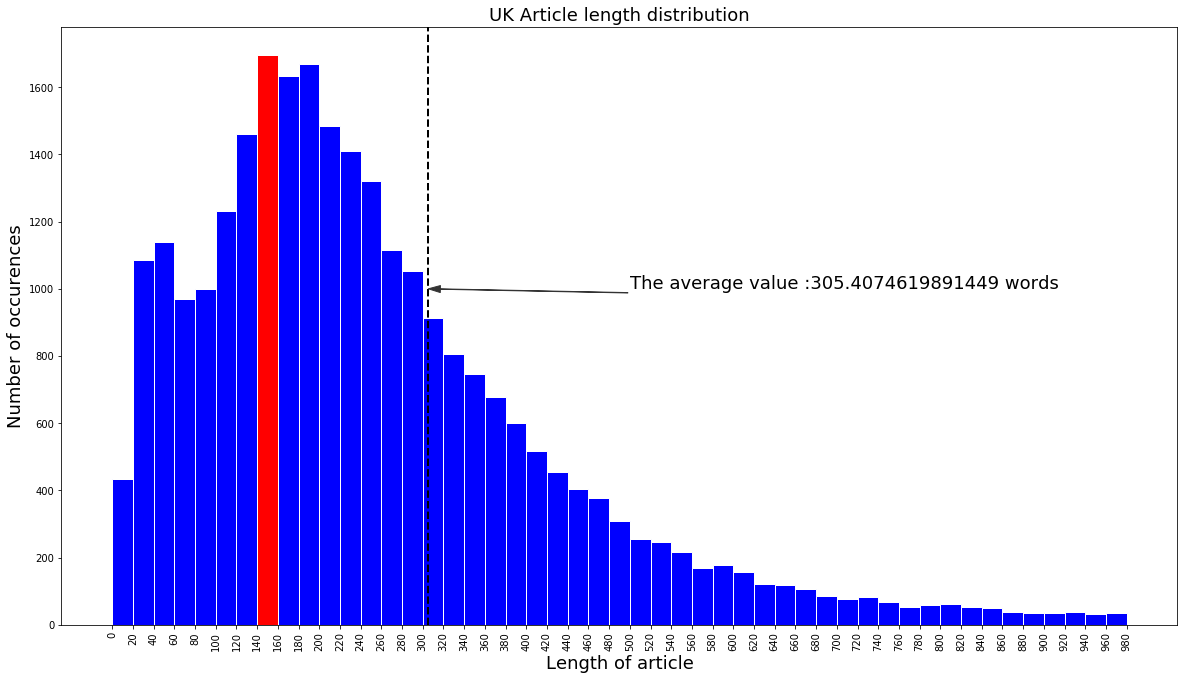

In [59]:
#plotting the Article length distribution
plt.figure(figsize=(20,11)) 

plt.xlabel("Length of article",fontsize=18)
plt.ylabel("Number of occurences",fontsize=18)
plt.title("UK Article length distribution",fontsize=18)
n, bins, patches = plt.hist(wrangled_data['length'],bins=range(0, 1000, 20),align='mid', edgecolor='white',color='b')
plt.xticks(rotation=90)
plt.xticks(np.arange(min(bins), max(bins)+1, 20))
patches[7].set_fc('r')
plt.axvline(wrangled_data['length'].mean(), color='k', linestyle='dashed', linewidth=2)
plt.annotate('The average value :'+str(wrangled_data['length'].mean())+ " words" , xy=(wrangled_data['length'].mean(), 1000), xytext=(500, 1000), fontsize=18, arrowprops={'width':0.4,'headwidth':7,'color':'#333333'})

In [148]:
# this is the data we feed our LDA 
import csv
data_lemmatized = list(processed_data['clean_text'])
with open("processed_uk_data", 'w', newline='') as myfile:
     wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
     wr.writerow(data_lemmatized)

> We compute bigrams in the articles. Bigrams are sets of two adjacent words. Using bigrams, we can get phrases like "email_address" in our output (spaces are replaced with underscores).

In [149]:
bigram = gensim.models.Phrases(data_lemmatized, min_count=20, threshold=100)
bigram_mod = gensim.models.phrases.Phraser(bigram)

texts = [bigram_mod[doc] for doc in data_lemmatized]

In [150]:
# Create Dictionary
id2word = corpora.Dictionary(texts)
# Filter out words that occur less than 15 documents, or more than 50% of the documents.
id2word.filter_extremes(no_below=2,no_above=0.5)

# Create Corpus
texts = texts

In [151]:
corpus = [id2word.doc2bow(text) for text in texts]

In [152]:
print('Number of unique tokens: %d' % len(id2word))
print('Number of documents: %d' % len(corpus))

Number of unique tokens: 79200
Number of documents: 27344


# 3. Topic Modeling using LDA 

## 3.1. Finding Optimal number of topics 

In [153]:
# range of topics you want to compute LDA for 
min_topic = 1
max_topic = 40
numberoftopics= list(range(min_topic,max_topic+1))

> In this part, we build multiple LDA models with different number of topics. <br> 
We compute the coherence score and perplexity score for each model.<br> These will be used to evaluate our LDA results and get the optimal number of topics.<br> 


In [154]:
#Sampling test data for perplexity 
# sample 1/300
import math 
from random import sample 
testset=sample(corpus,int(len(corpus)/300))

In [155]:
#Perplexity Score implementation : 

def perplexity(ldamodel, testset, dictionary, size_dictionary, num_topics):
    """calculate the perplexity of a lda-model"""
    print ('the info of this ldamodel: \n')
    print ('num of testset: %s; size_dictionary: %s; num of topics: %s'%(len(testset), size_dictionary, num_topics))
    prep = 0.0
    prob_doc_sum = 0.0
    topic_word_list = [] # store the probablity of topic-word
    for topic_id in range(num_topics):
        topic_word = ldamodel.show_topic(topic_id, size_dictionary)
        dic = {}
        for word, probability in topic_word:
            dic[word] = probability
        topic_word_list.append(dic)
    doc_topics_ist = [] #store the doc-topic tuples
    for doc in testset:
        doc_topics_ist.append(ldamodel.get_document_topics(doc, minimum_probability=0))
    testset_word_num = 0
    for i in range(len(testset)):
        prob_doc = 0.0 # the probablity of the doc
        doc = testset[i]
        doc_word_num = 0 # the num of words in the doc
        for word_id, num in doc:
            prob_word = 0.0 # the probablity of the word 
            doc_word_num += num
            word = dictionary[word_id]
            for topic_id in range(num_topics):
                # cal p(w) : p(w) = sumz(p(z)*p(w|z))
                prob_topic = doc_topics_ist[i][topic_id][1]
                prob_topic_word = topic_word_list[topic_id][word]
                prob_word += prob_topic*prob_topic_word
            prob_doc += math.log(prob_word) # p(d) = sum(log(p(w)))
        prob_doc_sum += prob_doc
        testset_word_num += doc_word_num
    prep = math.exp(-prob_doc_sum/testset_word_num) # perplexity = exp(-sum(p(d)/sum(Nd))
    print ("the perplexity of this ldamodel is : %s"%prep)
    return prep

In [166]:
# Build LDA model
cv_coherence_values = []
uci_coherence_values = []
umass_coherence_values = []
model_list = []
perplexity_values =[]
for i in numberoftopics:
    lda_model = gensim.models.ldamodel.LdaModel(corpus = corpus,
                                                id2word = id2word,
                                                num_topics =i , 
                                                alpha = 0.1,
                                                eta= 0.01,
                                                iterations=50,
                                                random_state=100,
                                                update_every=1,
                                                chunksize=2000,
                                                passes=4)
    model_list.append(lda_model)

    print("------------------------------------------------")
    print("number of topics" , i)
    #print('\nPerplexity: ', perplexity(lda_model, testset, id2word, len(id2word), i))
    #perplexity_values.append(perplexity(lda_model, testset, id2word, len(id2word), i))
    print(lda_model.print_topics())
    
    cv_coherence_values.append(CoherenceModel(model=lda_model, texts=texts, dictionary=id2word, coherence='c_v').get_coherence())
    uci_coherence_values.append(CoherenceModel(model=lda_model, texts=texts, dictionary=id2word, coherence='c_uci').get_coherence())
    umass_coherence_values.append(CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='u_mass').get_coherence())

------------------------------------------------
number of topics 1
[(0, '0.005*"brexit" + 0.004*"leave" + 0.004*"party" + 0.004*"deal" + 0.004*"uk" + 0.003*"police" + 0.003*"work" + 0.003*"vote" + 0.003*"man" + 0.003*"eu"')]
------------------------------------------------
number of topics 2
[(0, '0.013*"brexit" + 0.009*"party" + 0.009*"deal" + 0.007*"uk" + 0.007*"vote" + 0.007*"eu" + 0.006*"government" + 0.006*"labour" + 0.006*"leave" + 0.005*"leader"'), (1, '0.005*"police" + 0.004*"man" + 0.004*"child" + 0.004*"family" + 0.004*"woman" + 0.004*"leave" + 0.003*"work" + 0.003*"life" + 0.003*"live" + 0.003*"star"')]
------------------------------------------------
number of topics 3
[(0, '0.019*"brexit" + 0.013*"party" + 0.012*"deal" + 0.010*"vote" + 0.009*"eu" + 0.008*"labour" + 0.008*"uk" + 0.007*"leave" + 0.007*"election" + 0.007*"leader"'), (1, '0.007*"police" + 0.006*"man" + 0.005*"family" + 0.005*"woman" + 0.004*"child" + 0.004*"leave" + 0.004*"life" + 0.004*"star" + 0.004*"royal"

In [131]:
def display_topics(model):
    topics = model.show_topics(num_topics=model.num_topics, formatted=False, num_words=10)
    topics = map(lambda c: map(lambda cc: cc[0], c[1]), topics)
    df = pd.DataFrame(topics)
    df.columns = ['keyword {0}'.format(i) for i in range(1, 10+1)]
    return df

In [190]:
evaluation_measures = pd.DataFrame(
    {'Number_topics': numberoftopics,
     'U_mass': [round(num, 3) for num in umass_coherence_values],
     'C_V': [round(num, 3) for num in cv_coherence_values],
     'UCI':[round(num, 3) for num in uci_coherence_values]
    })
evaluation_measures

Number_topics  U_mass    C_V    UCI
0               1  -1.199  0.330 -0.168
1               2  -1.885  0.574  0.462
2               3  -1.736  0.514  0.354
3               4  -1.656  0.531  0.412
4               5  -1.613  0.504  0.376
5               6  -2.017  0.506  0.283
6               7  -2.268  0.516  0.210
7               8  -2.299  0.583  0.485
8               9  -2.076  0.570  0.549
9              10  -2.107  0.577  0.567
10             11  -2.207  0.558  0.409
11             12  -2.271  0.573  0.524
12             13  -2.173  0.597  0.559
13             14  -2.363  0.584  0.585
14             15  -2.377  0.593  0.580
15             16  -2.624  0.594  0.573
16             17  -2.469  0.587  0.517
17             18  -2.544  0.576  0.378
18             19  -2.338  0.584  0.612
19             20  -2.334  0.546  0.244
20             21  -2.368  0.586  0.489
21             22  -2.583  0.587  0.566
22             23  -2.467  0.598  0.552
23             24  -2.660  0.589  0.564
24             25  -2.378  0.587  0.583
25             26  -2.895  0.590  0.473
26             27  -2.592  0.590  0.450
27             28  -2.360  0.581  0.496
28             29  -2.918  0.577  0.405
29             30  -2.310  0.576  0.440
30             31  -2.511  0.574  0.508
31             32  -2.725  0.567  0.364
32             33  -2.565  0.594  0.544
33             34  -3.026  0.580  0.325
34             35  -2.731  0.570  0.286
35             36  -3.196  0.557  0.190
36             37  -2.840  0.565  0.168
37             38  -2.972  0.564  0.236
38             39  -2.948  0.567  0.266
39             40  -3.027  0.561  0.104

In [260]:
for i  in [18]:
    model_list[i].save("uk_model{}.gensim".format(i+1))

'''finding the optimal number of topics is to build
many LDA models with different values of number of topics (k) 
and pick the one that gives the highest coherence value.
Best coherence for umass is typically the minimum
'''

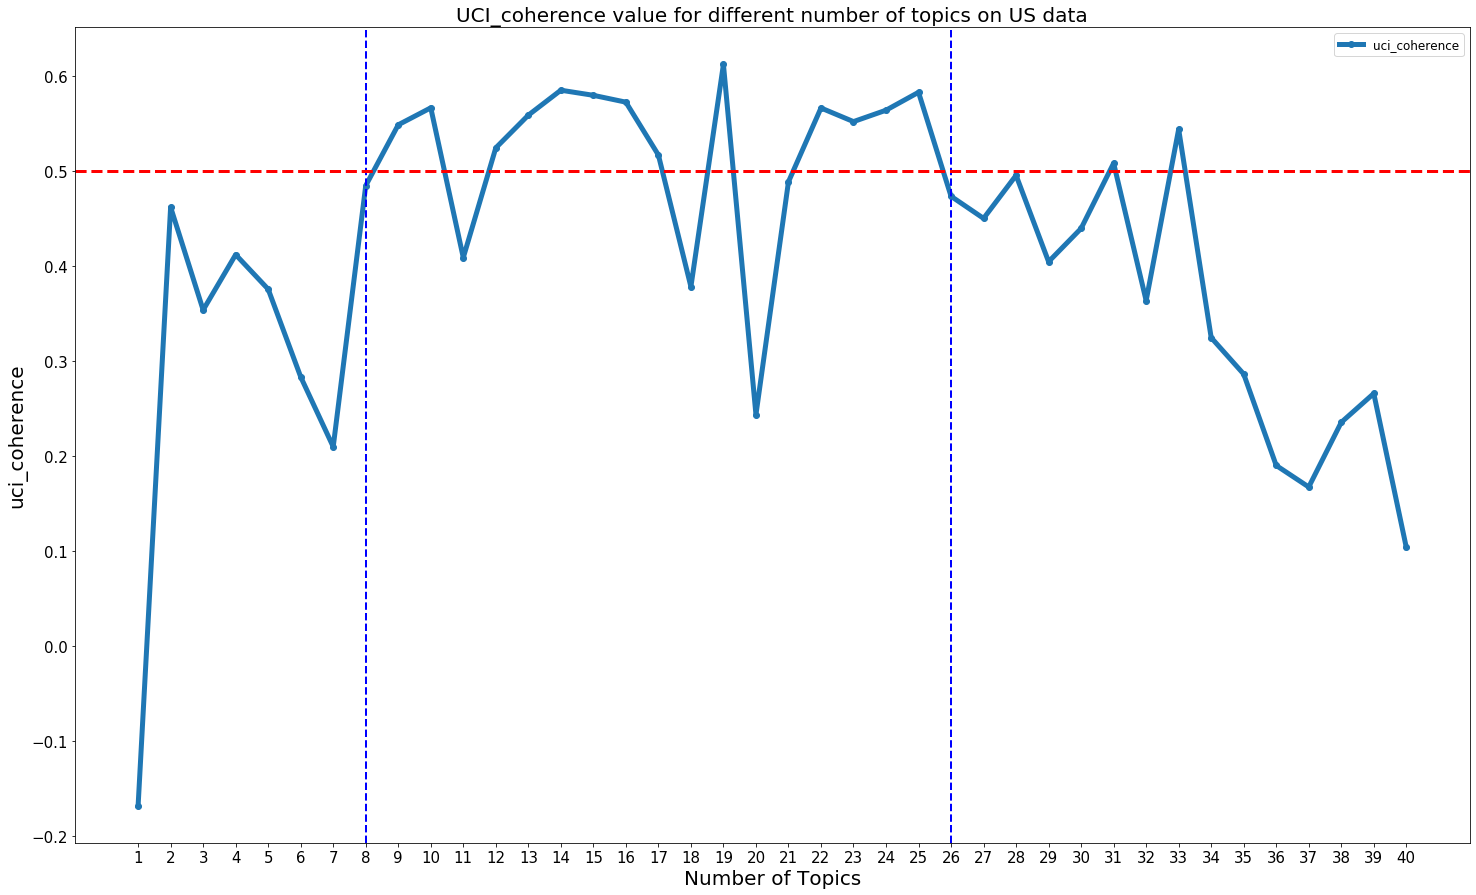

In [493]:
def Average(lst): 
    return sum(lst) / len(lst) 


# Show graph
plots = pd.DataFrame({"topics" : numberoftopics ,
                     "cv_coherence" :cv_coherence_values ,
                     "uci_coherence" :uci_coherence_values,
                     "umass":umass_coherence_values })
plots.plot(x="topics",y=["uci_coherence"],figsize=(25,15),   linestyle='-', linewidth=5, marker='o',fontsize=15)
plt.xlabel("Number of Topics", fontsize=20)
plt.ylabel("uci_coherence", fontsize=20)
plt.axvline(x=8, linewidth=2, color='b', linestyle='--' )
#plt.axvline(x=28, linewidth=2, color='b', linestyle='--' )
plt.axvline(x=26, linewidth=2, color='b', linestyle='--' )
plt.gca().set_xticks(plots["topics"].unique())
plt.axhline(y=0.5, linewidth=3, color='r' ,  linestyle='--')
plt.title(("UCI_coherence value for different number of topics on US data"),fontsize=20)
plt.show()

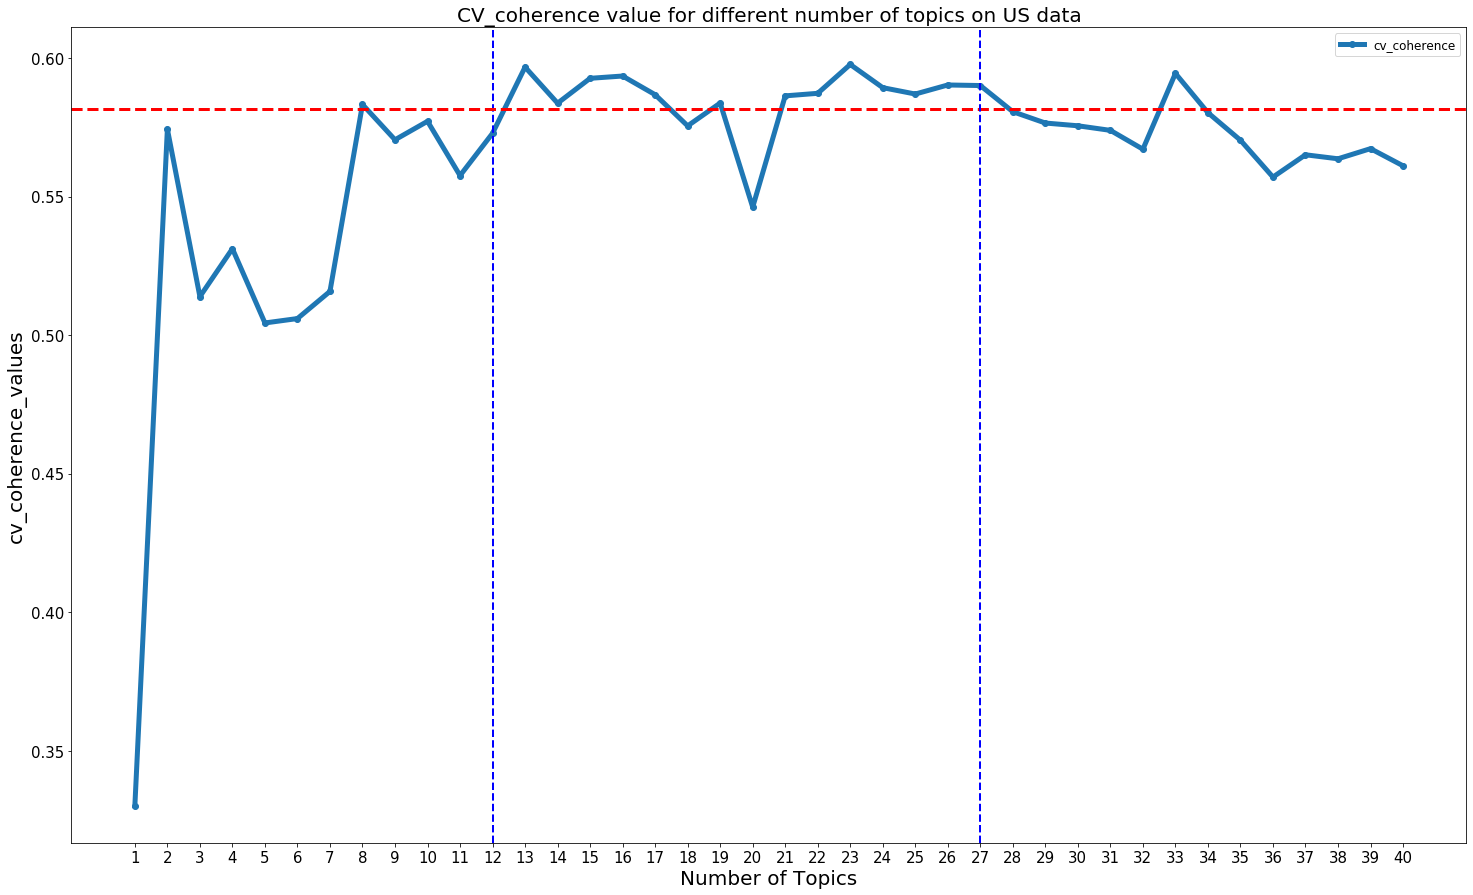

In [492]:
plots.plot(x="topics",y=["cv_coherence"],figsize=(25,15),   linestyle='-', linewidth=5, marker='o',fontsize=15)
plt.xlabel("Number of Topics", fontsize=20)
plt.ylabel("cv_coherence_values", fontsize=20)
plt.axvline(x=12, linewidth=2, color='b', linestyle='--' )
plt.axhline(y=Average(cv_coherence_values[8:25]), linewidth=3, color='r' ,  linestyle='--')
plt.axvline(x=27, linewidth=2, color='b', linestyle='--' )
plt.gca().set_xticks(plots["topics"].unique())
#plt.axhline(y=0.55, linewidth=3, color='r' ,  linestyle='--')
plt.title(("CV_coherence value for different number of topics on US data"),fontsize=20)
plt.show()

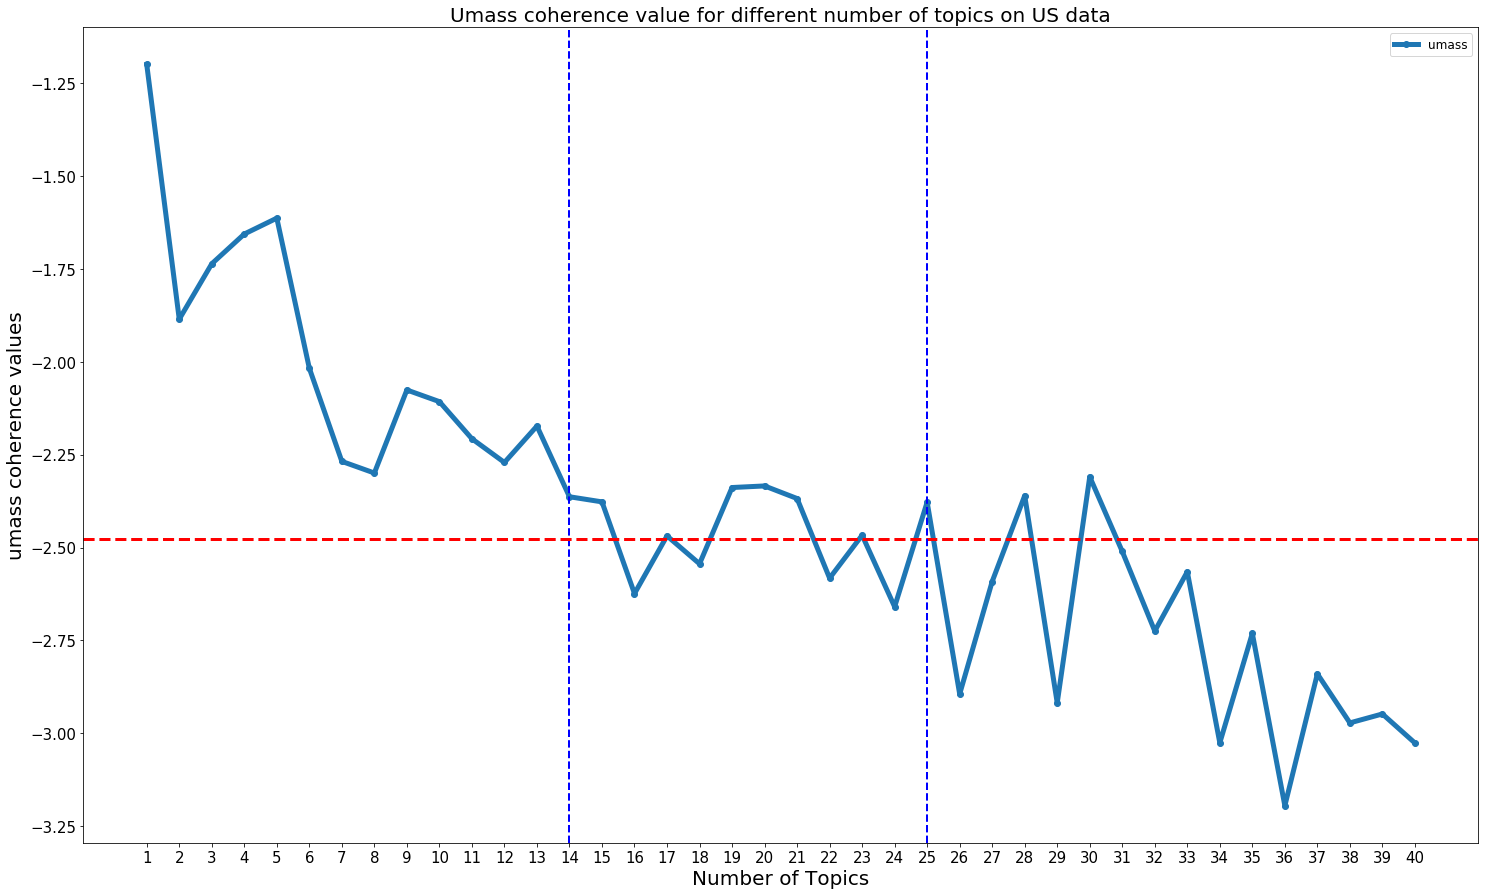

In [494]:

plots.plot(x="topics",y="umass",figsize=(25,15),   linestyle='-', linewidth=5, marker='o',fontsize=15)
plt.xlabel("Number of Topics", fontsize=20)
plt.ylabel("umass coherence values", fontsize=20)
plt.axvline(x=14, linewidth=2, color='b', linestyle='--' )
plt.axhline(y=Average(umass_coherence_values[15:25]), linewidth=3, color='r' ,  linestyle='--')
plt.axvline(x=25, linewidth=2, color='b', linestyle='--' )
plt.gca().set_xticks(plots["topics"].unique())
#plt.axhline(y=0.55, linewidth=3, color='r' ,  linestyle='--')
plt.title(("Umass coherence value for different number of topics on US data"),fontsize=20)
#plt.ylim([-4,-1])
plt.show()

In [238]:
display_topics(model=model_list[22]) 

keyword 1             keyword 2   keyword 3     keyword 4       keyword 5  \
0      brexit                 party        deal          vote              eu   
1       beach                flight       plane           air             fly   
2     country                   war      attack    government           group   
3     johnson             secretary  leadership       veteran  lady_gabriella   
4       court                  case      charge         claim          report   
5        wear                 dress       black         white            star   
6      police                   man      attack       officer             car   
7        work                school  government         child      university   
8       woman                  feel         man      question            book   
9         win                  game        play          team         england   
10  cathedral                church       paris          king          family   
11    council                   car       house    notre_dame           local   
12    company              business       price      customer              uk   
13       club                season      player     liverpool         chelsea   
14       food               patient      health           eat            body   
15     family                 child      credit         leave            life   
16    reuters               england       woman        sketch     enter_email   
17      north                 south        city          east            west   
18       star                  film        love           fan            play   
19      trump             president       visit  donald_trump           house   
20       post               twitter       video      facebook          social   
21    protest  extinction_rebellion   protester         china        activist   
22      royal                  baby      meghan         queen           harry   

         keyword 6      keyword 7      keyword 8        keyword 9  \
0           labour       election            mps             tory   
1        passenger          crash        airport            water   
2            force       military        british         national   
3             race          today  boris_johnson         normandy   
4           prison  investigation          judge         sentence   
5             pair        wedding          style             hair   
6            woman           kill         murder           arrest   
7               uk        support        student           report   
8           change          write            sex             fact   
9            final         player          match            point   
10             die         french           roof            hotel   
11           build           work       building             site   
12           store           firm           sell              buy   
13             pay           city       football             goal   
14          doctor           drug             dr        treatment   
15          mother       daughter         friend              mum   
16   email_address  create_sketch   shape_create               uk   
17         service          wales          train               uk   
18          series          actor             tv            music   
19         protest         leader          white             meet   
20         comment          tweet      instagram             user   
21  climate_change         police        reuters  waterloo_bridge   
22           birth         prince          child           family   

           keyword 10  
0               leave  
1                boat  
2                iran  
3               serve  
4                 law  
5                pose  
6            hospital  
7              number  
8                talk  
9               sport  
10               work  
11               park  
12                pay  
13                fan  
14           hospital  
15                

### Word intrusion task 

In [236]:
#based on the previous figure 
import random 
eval_data= display_topics(model=model_list[18])
l= list(eval_data["keyword 1"])
print(eval_data)
shuffled_words_intrusion = random.sample(l, len(l))
eval_data["keyword 1"]= shuffled_words_intrusion
shuffled_eval =pd.DataFrame(np.apply_along_axis(np.random.permutation, 1, eval_data))
shuffled_eval['intruder']=shuffled_words_intrusion

    keyword 1  keyword 2   keyword 3             keyword 4   keyword 5  \
0      brexit      party        deal                  vote          eu   
1      credit     flight       plane                   fly       beach   
2       trump  president     country                   war  government   
3       royal      queen        baby                meghan       harry   
4        case      court       claim                report         law   
5        wear      dress       black                  star        pair   
6      police        man      attack               officer       woman   
7        work     school  government                 child          uk   
8        feel      woman       write                   man        post   
9         win       game        play                  team      player   
10  cathedral      paris  notre_dame                church      french   
11    council        car       house                 local        city   
12    company   business    customer  

In [388]:
#based on the previous figure 
import random 
eval_data= display_topics(model=model_list[21])
l= list(eval_data["keyword 1"])
print(eval_data)
shuffled_words_intrusion = random.sample(l, len(l))
eval_data["keyword 1"]= shuffled_words_intrusion
shuffled_eval =pd.DataFrame(np.apply_along_axis(np.random.permutation, 1, eval_data))
shuffled_eval['intruder']=shuffled_words_intrusion

     keyword 1  keyword 2 keyword 3   keyword 4   keyword 5     keyword 6  \
0     facebook    company    online      people        user        report   
1       people     flight     plane         air   passenger       service   
2    cathedral       film     paris  notre_dame      french        series   
3         club     player       win        game      season          play   
4        child     people    school      health  university       student   
5       london        day   england      people       match     edinburgh   
6        court      woman      case         law      charge        prison   
7         food        day      feel         eat      people          good   
8        build      water  building       house        work          site   
9       brexit       deal        eu        vote         mps            uk   
10         car       road    driver       drive     vehicle        police   
11      people      tweet      news     comment       claim       twitter   

In [379]:
shuffled_words_intrusion

['company',
 'court',
 'child',
 'police',
 'london',
 'brexit',
 'party',
 'win',
 'people',
 'royal',
 'trump',
 'water',
 'film']

In [275]:
#enter the optimal number of topics 
lda_model=model_list[18]

In [333]:
for i,topic in lda_model.show_topics(formatted=False, num_topics=29, num_words=10):
    print('Topic {}: {}'.format(i, [w[0] for w in topic]))

Topic 0: ['brexit', 'party', 'deal', 'vote', 'eu', 'labour', 'election', 'tory', 'mps', 'leave']
Topic 1: ['credit', 'flight', 'plane', 'fly', 'beach', 'air', 'passenger', 'crash', 'airport', 'animal']
Topic 2: ['trump', 'president', 'country', 'war', 'government', 'force', 'military', 'leader', 'china', 'donald_trump']
Topic 3: ['royal', 'queen', 'baby', 'meghan', 'harry', 'prince', 'wedding', 'birth', 'family', 'visit']
Topic 4: ['case', 'court', 'claim', 'report', 'law', 'charge', 'investigation', 'woman', 'public', 'legal']
Topic 5: ['wear', 'dress', 'black', 'star', 'pair', 'white', 'instagram', 'love', 'daughter', 'couple']
Topic 6: ['police', 'man', 'attack', 'officer', 'woman', 'arrest', 'car', 'road', 'incident', 'kill']
Topic 7: ['work', 'school', 'government', 'child', 'uk', 'university', 'student', 'support', 'high', 'report']
Topic 8: ['feel', 'woman', 'write', 'man', 'post', 'twitter', 'social', 'good', 'lot', 'life']
Topic 9: ['win', 'game', 'play', 'team', 'player', 'ci

In [347]:
# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline


# Visualize the topics K= 13
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(model_list[12], corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
7     -0.169025  0.105654       1        1  12.757351
9      0.147991 -0.164343       2        1  10.535506
0      0.003398 -0.132256       3        1  10.007980
8     -0.017488  0.064551       4        1   9.795139
4     -0.093818 -0.065317       5        1   9.558600
10    -0.061256  0.126316       6        1   8.486257
2      0.113124  0.066518       7        1   7.183530
1     -0.144257  0.060682       8        1   6.686038
6     -0.005127 -0.103320       9        1   6.060170
11    -0.117549 -0.073063      10        1   5.721442
12     0.150094 -0.129895      11        1   5.127856
3     -0.063657  0.018660      12        1   4.737448
5      0.257570  0.225812      13        1   3.342680, topic_info=                Term          Freq         Total Category  logprob  loglift
728            party  29871.000000  29871.000000  Default  30.0000  30.0000
19            brexit  34595.000000  34595.000000  Default  29.0000  29.0000
445           london  27168.000000  27168.000000  Default  28.0000  28.0000
1736          police  26566.000000  26566.000000  Default  27.0000  27.0000
197             vote  19864.000000  19864.000000  Default  26.0000  26.0000
...              ...           ...           ...      ...      ...      ...
119       parliament   1545.436035  10219.736328  Topic13  -5.1446   1.5094
129   prime_minister   1445.468262  12089.050781  Topic13  -5.2115   1.2745
934          british   1414.319092  11168.905273  Topic13  -5.2332   1.3319
1569          action   1352.764526   6140.390137  Topic13  -5.2777   1.8857
3113           trump   1366.562988  12746.925781  Topic13  -5.2676   1.1654

[1240 rows x 6 columns], token_table=       Topic      Freq       Term
term                             
24443      6  0.984078     abduct
24443      7  0.015082     abduct
12206      6  1.000748  abduction
208        5  0.012777   abortion
208        9  0.987002   abortion
...      ...       ...        ...
4313       7  0.867922    zealand
4313       8  0.013785    zealand
4313       9  0.000511    zealand
4313      10  0.004084    zealand
4313      12  0.020422    zealand

[4588 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[8, 10, 1, 9, 5, 11, 3, 2, 7, 12, 13, 4, 6])

In [349]:
# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline


# Visualize the topics K= 18
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(model_list[17], corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
13    -0.189304  0.033240       1        1  10.671689
9      0.167137 -0.099671       2        1   9.045432
14    -0.198296  0.059710       3        1   7.585011
0      0.062929 -0.196782       4        1   7.501709
8      0.009525  0.002289       5        1   7.103199
4     -0.023944 -0.119111       6        1   6.762650
17     0.010095  0.160427       7        1   5.912034
12     0.184562 -0.070987       8        1   5.397263
7     -0.157258 -0.127464       9        1   5.339249
6      0.070279 -0.013055      10        1   4.878330
11    -0.009535 -0.047353      11        1   4.327491
15    -0.132556  0.108116      12        1   4.232581
3     -0.023129 -0.025096      13        1   4.154842
2      0.137564  0.167279      14        1   3.705778
10    -0.100793  0.078012      15        1   3.683929
1     -0.010185  0.087338      16        1   3.629780
16     0.006902 -0.185541      17        1   3.295286
5      0.196006  0.188650      18        1   2.773747, topic_info=                Term          Freq         Total Category  logprob  loglift
19            brexit  34985.000000  34985.000000  Default  30.0000  30.0000
728            party  29857.000000  29857.000000  Default  29.0000  29.0000
445           london  27153.000000  27153.000000  Default  28.0000  28.0000
1736          police  25443.000000  25443.000000  Default  27.0000  27.0000
197             vote  19942.000000  19942.000000  Default  26.0000  26.0000
...              ...           ...           ...      ...      ...      ...
643            woman   1765.201172  20489.113281  Topic18  -4.8251   1.1333
658          britain   1346.992676  10253.140625  Topic18  -5.0955   1.5553
1736          police   1586.731689  25443.603516  Topic18  -4.9317   0.8102
129   prime_minister   1301.468140  12021.675781  Topic18  -5.1299   1.3618
934          british   1284.996216  11006.267578  Topic18  -5.1427   1.4373

[1619 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
208       3  0.025868  abortion
208       6  0.001617  abortion
208      10  0.973295  abortion
1         2  0.018096    access
1         3  0.005677    access
...     ...       ...       ...
4313     11  0.011805   zealand
4313     12  0.074939   zealand
4313     13  0.022584   zealand
4313     14  0.007699   zealand
4313     16  0.027204   zealand

[7032 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[14, 10, 15, 1, 9, 5, 18, 13, 8, 7, 12, 16, 4, 3, 11, 2, 17, 6])

In [333]:
# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

#K= 22

# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(model_list[21], corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
9     -0.127439 -0.158107       1        1  9.149121
0     -0.053516 -0.168376       2        1  8.418096
13     0.224117  0.068298       3        1  7.289232
14     0.158050  0.069715       4        1  6.201110
7      0.186748 -0.034658       5        1  6.105383
17    -0.049281  0.103635       6        1  5.850330
8     -0.018367  0.041608       7        1  5.545111
4      0.005041 -0.111704       8        1  5.399607
2      0.107344 -0.099186       9        1  5.009701
12    -0.118558 -0.123508      10        1  4.737675
19     0.163343  0.033669      11        1  4.461677
18    -0.144038 -0.023504      12        1  4.423773
11    -0.038755 -0.130161      13        1  4.195000
6     -0.060825 -0.140895      14        1  3.890897
3      0.039285  0.008176      15        1  3.632694
15     0.147089  0.096348      16        1  3.356822
1     -0.087819  0.117252      17        1  3.143761
20    -0.207523  0.196517      18        1  2.638028
10     0.012380  0.119987      19        1  2.445246
16     0.044841 -0.041445      20        1  2.407328
5     -0.182117  0.176341      21        1  1.699409, topic_info=            Term          Freq         Total Category  logprob  loglift
19        brexit  34573.000000  34573.000000  Default  30.0000  30.0000
728        party  29998.000000  29998.000000  Default  29.0000  29.0000
1736      police  25327.000000  25327.000000  Default  28.0000  28.0000
445       london  26185.000000  26185.000000  Default  27.0000  27.0000
197         vote  19910.000000  19910.000000  Default  26.0000  26.0000
...          ...           ...           ...      ...      ...      ...
1138         win    815.067444  13783.931641  Topic21  -5.1080   1.2469
712       leader    722.058350  14503.556641  Topic21  -5.2291   1.0748
964        great    686.356934  10121.593750  Topic21  -5.2798   1.3839
437        leave    726.610046  33354.875000  Topic21  -5.2228   0.2483
119   parliament    595.598450  10165.752930  Topic21  -5.4217   1.2377

[1882 rows x 6 columns], token_table=       Topic      Freq      Term
term                            
24443      6  0.997219    abduct
208       14  0.999791  abortion
23717      6  0.995429  abu_bakr
2429       2  0.000691     abuse
2429       3  0.000691     abuse
...      ...       ...       ...
4313      15  0.020332   zealand
4313      16  0.078279   zealand
4313      17  0.039648   zealand
20515     19  1.003464   ‹_slide
20516     19  1.003464         ›

[8912 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[10, 1, 14, 15, 8, 18, 9, 5, 3, 13, 20, 19, 12, 7, 4, 16, 2, 21, 11, 17, 6])

## Assigning a topic to each article:

In [506]:
# Create a dictionary in which the keys are the topic numbers and the value is 1 for the topic of the record and 0 otherwise

In [508]:
new_top = []
for i in range(len(data_lemmatized)):
    new_dic = {k: 0 for k in  range(0,19)}
    test = lda_model.get_document_topics(corpus[i])
    cv = max(test, key=lambda x:x[1])[0]
    for j in range(0,23):
        if j == cv: 
            new_dic[j] = new_dic[j]+1
        else : 
            continue 
  
    new_top.append(new_dic)


In [509]:
l=[]
for i in range(len(data_lemmatized)):
    l.append(max(lda_model.get_document_topics(corpus[i]), key=lambda x:x[1]))

In [510]:
processed_data["top_topic"]= l
processed_data["topic_distribution"]=new_top

/home/meftahzi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/home/meftahzi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [511]:
top_dict = dict(zip(processed_data["dup_index"], processed_data["top_topic"]))
dis_dict = dict(zip(processed_data["dup_index"], processed_data["topic_distribution"]))

In [512]:
top_topic = []
topic_dist =[]
for i in range(len(data)): 
    var = data['dup_index'].iloc[i]
    if var in top_dict : 
        top_topic.append(top_dict[var]) 
        topic_dist.append(dis_dict[var]) 
    else :         
        top_topic.append(float("nan")) 
        topic_dist.append(float("nan")) 
data["top_topic"]= top_topic
data["topic_distribution"]=topic_dist

In [513]:
#final dataset with all information included 
final = data[['panelist_id',"combined","top_topic","topic_distribution","dup_index"]]
final = data.dropna(subset=['top_topic'])

In [514]:
#number of panelists and the number of articles they read
pd.DataFrame(final.panelist_id.value_counts())

panelist_id
a039264254276179         3133
0186afc39055590a         2426
3cca9a0b1908da80         2309
cd36f689f65231b0         1748
f1749631b8687508         1396
b503ba00dac1956c         1329
2fba1002df39d4af         1201
c5742ca8a0379047         1185
ba27c45c288269f5         1103
d0093ff10a8981dd         1087
23961d16bc55402c         1078
b868d7c531c4dca0         1029
d432fd73db4d32cb          958
f029a80b79d2fa83          918
0449943bb9b92714          895
4dbf8d89d10604aa          864
26f950878fb1d4cb          860
233d06fcc4fa3615          852
20169bd8a6896b8c          834
133827c533b78649          832
419c7b1baa178cd9          830
cdfb62699c91c741          824
593233b7f69b15f0          823
6c2b0bd91af8295d          823
789ba70b0dcc9fa6          799
dd89d8a456ff4ca7          768
15015c0a158a708a          760
f311895640f3871a          746
df9d16115f34f16f          723
f6a1d1741aa596f3          704
d78c84d2629868db          685
41a7c30d2227d1d4          679
d57b30f5c364302f          649
60d39bd3366df363          609
bcd353af9c257844          609
ac30a7b66450041f          605
468d62c71096cdb5          600
caa901614f039f20          598
f9d2c2d40c429064          589
574a2a0674067829          560
8478a7a02123db2d          559
2fc17a6fc495c473          550
5d7c01791304af11          535
8746059c24a48b95          530
74a34b40a01fa8f5          519
3dccb56457075df4          518
1d536d48a445a988          498
cf25b06208c531fa          493
7bb44811273cb90c          487
5bca336f3d4f4398          487
d4d91fab9f03470d          474
48b8fafa94ba879f          440
25b6d6386b780660          438
800556cafb099fc9          438
9c837ff2933c199b          434
88ff14b45a8d0547          412
ba89b35c46b1864a          409
52b69f3f7a591dbf          407
acfd977a607674f7          400
4980b0c665f00600          395
c922a6f2a4782396          391
6a43965ab55f2ac2          371
8dc1b8b230c6468b          363
a6168b9654790f5b          362
054c02429f1fa008          360
61c98bb7631996d0          358
1b2d20d6cdc08d70          358
98d790759ac21101          357
2240c27ba8fd4b62          353
7c546b9980541900          339
7c693bb3834c1983          319
d85146dcc8d8dc0f          316
ba7373a7c335bc05          301
328d3f76821b004a          286
c94831b19da2999b          282
bb017f094829f756          277
cf2d2045f6c78925          273
1cc63bbc958a450f          270
925a9b1dcc406635          267
41c01660f481d610          266
4f9580a1c3bba238          264
1dda9055c81c88b5          262
b8cc461ddd71c527          256
48bf370b9c615c6a          250
c80f19fc385d3387          248
c289516a6c855771          245
369ffca5c02c7d8d          238
f52f779886019dc4          232
f792f540a001b56d          229
32abb6ff05b1421a          225
054c999b11a92d93          224
48947af1afb8fafc          222
4d9bc2a3af894df8          218
f7b42cc2aac4f1d0          217
634093f8f0781183          215
0340dab53179162f          212
36cfbd805fabb226          212
8df648494846b430          211
03da686a16f7a66d          209
c59826ba5d5c88b2          206
afcc4faf82aa2919          204
bc68c156add04bca          201
041f1081f50f3720          198
f7c81971757b8a42          196
870978d6dcf7399c          193
369d9ca2679ad7d0          191
bd19b019577d2724          189
70001965412f258b          188
8d7ff18c84b61492          187
13667cb87bc0fa24          186
802b3c438c4350d8          182
420c18484a90a443          182
0b53f909f1d504d7          179
bdf4866ccb9908c6          175
333c464a1273d721          174
0c713d90c6c83cf4          172
df813bf777ba7962          172
70d34a6d16d425c3          170
091a4a5894441214          169
26b62a25aab1d240          169
996653899d8076c8          169
9d6f5ab0b2000f84          168
88a9751012508c7d          164
215b149fba54d08c          160
66605ca5b58dcd2b          158
6d0aa6c445a195b9          157
a1c9752697c3a3af          156
7510a06ac59ac83d          155
883d8fac05341446          154
9dc0ddf41dcf1672          154
251c084776f16d36          154
6f79fd120d984d7b          153
ca7f432125bf8987          15

In [515]:
# Number of Documents for Each Topic
topic = final['top_topic'].apply(lambda x: x[0])
topic_perce= final['top_topic'].apply(lambda x: x[1])
topic_counts=topic.value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)


# Concatenate Column wise
df_dominant_topics = pd.concat([topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Num_Documents', 'Perc_Documents']

# Show

df_dominant_topics['dominant_topic'] = df_dominant_topics.index
df_dominant_topics

Num_Documents  Perc_Documents  dominant_topic
0           15650          0.1908               0
18           7640          0.0931              18
6            7110          0.0867               6
7            6342          0.0773               7
12           5787          0.0706              12
4            4532          0.0553               4
11           4505          0.0549              11
15           3944          0.0481              15
8            3663          0.0447               8
14           3393          0.0414              14
2            3222          0.0393               2
5            3046          0.0371               5
1            2586          0.0315               1
9            2392          0.0292               9
17           2256          0.0275              17
13           2185          0.0266              13
10           1714          0.0209              10
3            1488          0.0181               3
16            567          0.0069              16

In [516]:
df = display_topics(model=model_list[18])
df.index = df.index.map(str)
df_dominant_topics.index = df_dominant_topics.index.map(str)
df=df.join(df_dominant_topics,how='outer')
df= df.sort_values(by=['Num_Documents'],ascending=False)
df

keyword 1  keyword 2   keyword 3             keyword 4   keyword 5  \
0      brexit      party        deal                  vote          eu   
18       star       film        love                  play         fan   
6      police        man      attack               officer       woman   
7        work     school  government                 child          uk   
12    company   business    customer                 price       store   
4        case      court       claim                report         law   
11    council        car       house                 local        city   
15     family      child      mother                  life       death   
8        feel      woman       write                   man        post   
14     health    patient    hospital                doctor        body   
2       trump  president     country                   war  government   
5        wear      dress       black                  star        pair   
1      credit     flight       plane                   fly       beach   
9         win       game        play                  team      player   
17      north      south     service                  east       water   
13        pay       bank        club               chelsea      season   
10  cathedral      paris  notre_dame                church      french   
3       royal      queen        baby                meghan       harry   
16    protest    reuters   protester  extinction_rebellion    activist   

         keyword 6      keyword 7     keyword 8 keyword 9    keyword 10  \
0           labour       election          tory       mps         leave   
18          series             tv         actor     leave          life   
6           arrest            car          road  incident          kill   
7       university        student       support      high        report   
12              uk           firm          sell       buy       product   
4           charge  investigation         woman    public         legal   
11           build           park        street      work          road   
15           leave          court      daughter       son         month   
8          twitter         social          good       lot          life   
14             eat          woman          food      drug     treatment   
2            force       military        leader     china  donald_trump   
5            white      instagram          love  daughter        couple   
1              air      passenger         crash   airport        animal   
9             city          final         match   england      football   
17            west          train            uk    monday         blaze   
13       liverpool          money        united       tax       arsenal   
10          france          hotel        family   century          king   
3           prince        wedding         birth    family         visit   
16  climate_change          group  demonstrator    police    parliament   

    Num_Documents  Perc_Documents  dominant_topic  
0           15650          0.1908               0  
18           7640          0.0931              18  
6            7110          0.0867               6  
7            6342          0.0773               7  
12           5787          0.0706              12  
4            4532          0.0553               4  
11           4505          0.0549              11  
15           3944          0.0481              15  
8            3663          0.0447               8  
14           3393          0.0414              14  
2            3222          0.0393               2  
5            3046          0.0371               5  
1            2586          0.0315               1  
9            2392          0.0292               9  
17           2256          0.0275              17  
13           2185          0.0266              13  
10           1714          0.0209              10  
3            1488          0.0181               3  
16            567          0.0069 

In [517]:
import matplotlib.colors as mcolors
from collections import Counter
topics = lda_model.show_topics(formatted=False)
data_flat = [w for w_list in data_lemmatized for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

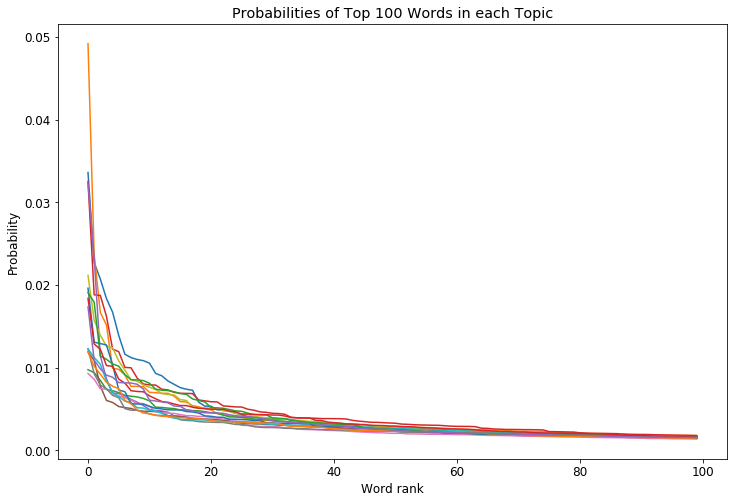

In [518]:
# change default figure and font size
plt.rcParams['figure.figsize'] = 12, 8 
plt.rcParams['font.size'] = 12

# top 100 words by weight in each topic
top_n_words = 100
topics = lda_model.show_topics(
    num_topics = 15, num_words = top_n_words, formatted = False)

for _, infos in topics:
    probs = [prob for _, prob in infos]
    plt.plot(range(top_n_words), probs)

plt.xlabel('Word rank')
plt.ylabel('Probability')
plt.title('Probabilities of Top 100 Words in each Topic')
plt.show()

'''
We started off by inspecting the top w=10 most probable words for each topic. The choice of w was based on the output of the sum of probabilities corresponding to top w∈[0,100] words in a topic by weight for different models'''

In [519]:
sent_topics_df = final[["combined"]]

In [520]:
b = [token[1] for token in final['top_topic']]
s = [token[0] for token in final['top_topic']]
final["topic"]= s
final["top_topic_Contribution"]= b

/home/meftahzi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/meftahzi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [521]:
def kew(topic_num):
    wp = lda_model.show_topic(topic_num)
    topic_keywords = ", ".join([word for word, prop in wp])
    return(topic_keywords)

In [522]:
final["topic_keywords"]= final["topic"].map(lambda token: kew(token))

/home/meftahzi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [524]:
final.sample(10)

title  \
305348  ALEX BRUMMER: Would No Deal Brexit really be t...   
320242  Preston dawn raids: Men arrested in rape and d...   
41741   Hull City bring curtain down on season with Br...   
371502  Mali attack: More than 130 Fulani villagers ki...   
123982  Emmerdale viewers 'broken' as Lisa Dingle dies...   
400172  What Attenborough told BBC viewers about this ...   
11574   Boxing results: Billy Joe Saunders and Josh Ta...   
439997          Les Reed: Delilah songwriter dies aged 83   
448078  Nick Ross says 'foolish' detectives hampered i...   
315410  Zuzana Caputova becomes Slovakia's first femal...   

                                                     text  \
305348  The easy thing for quarrelsome MPs and Remain ...   
320242  Three men have been held on suspicion of rape ...   
41741   Get the biggest Hull City stories by email Sub...   
371502  Image copyright Getty Images Image caption Ful...   
123982  Emmerdale fans were left devastated on Thursda...   
400172  One of the most talked-about programmes of the...   
11574   Boxing results LIVE: Billy Joe Saunders and Jo...   
439997  Image copyright Getty Images Image caption Les...   
448078  Former Crimewatch presenter Nick Ross has clai...   
315410  Image copyright Reuters Image caption Zuzana C...   

                                                  authors  \
305348                ['Alex Brummer For The Daily Mail']   
320242                                                NaN   
41741   ['Philip Buckingham', 'Image', 'Russell Hart F...   
371502                                                NaN   
123982                    ['Niomi Harris For Mailonline']   
400172              ['David Rose For The Mail On Sunday']   
11574                                     ['Joshua Peck']   
439997                                                NaN   
448078                  ['Danyal Hussain For Mailonline']   
315410                                                NaN   

                                                     imgs meta_lang  \
305348  ['https://i.dailymail.co.uk/1s/2019/01/09/13/8...        en   
320242  ['https://a1.api.bbc.co.uk/hit.xiti?&col=1&fro...        en   
41741   ['https://i2-prod.hulldailymail.co.uk/sport/fo...       NaN   
371502  ['http://ssc.api.bbc.com/?c1=2&c2=19293874&ns_...        en   
123982  ['https://i.dailymail.co.uk/1s/2019/09/15/10/1...        en   
400172  ['https://i.dailymail.co.uk/1s/2019/08/15/08/1...        en   
11574   ['https://cdn.images.express.co.uk/img/page/pl...        en   
439997  ['http://ssc.api.bbc.com/?c1=2&c2=19293874&ns_...        en   
448078  ['https://i.dailymail.co.uk/1s/2019/08/05/01/1...        en   
315410  ['http://ssc.api.bbc.com/?c1=2&c2=19293874&ns_...        en   

                                            meta_keywords  \
305348        ['dailymail', 'money', 'comment', 'brexit']   
320242                                               ['']   
41741                                       ['Hull City']   
371502                                               ['']   
123982                         ['dailymail', 'tvshowbiz']   
400172  ['dailymail', 'news', 'climate-change-&-global...   
11574                                                ['']   
439997                                               ['']   
448078                    ['dailymail', 'news', 'london']   
315410                                               ['']   

                                  htmlfile  \
305348  GER_2019-03-30_40125_web_page.html   
320242  GER_2019-03-27_24773_web_page.html   
41741   GER_2019-05-05_71298_web_page.html   
371502  GER_2019-03-24_12358_web_page.html   
123982   GER_2019-05-24_2697_web_page.html   
400172  GER_2019-04-21_37621_web_page.html   
11574    GER_2019-05-18_6991_web_page.html   
439997   GER_2019-04-16_7224_web_page.html   
448078  GER_2019-04-13_21914_web_page.html   
315410  GER_2019-03-31_27039_web_page.html   

                                                      url       panelist_id

# Document sampling for topic labeling 

In [329]:
# function that takes the topic number and the number of documents to show and returns the texts with the highest probabilities from the topic.
# Taking a high doc_num displays all document within the topic
def closest(topic_num, doc_num):
    v= final[final["topic"]==topic_num]
    v= v.nlargest(doc_num, 'top_topic_Contribution')
    return(v)

In [405]:
new_list=closest(18,150)
new_list["text"]

30152     Shirley Ballas has revealed she feels as thoug...
30886     Shirley Ballas has revealed she feels as thoug...
503233    Faye Brookes has reportedly quit her role as K...
402592    Coronation Street star Faye Brookes has quit t...
402593    Coronation Street star Faye Brookes has quit t...
404665    Coronation Street star Faye Brookes has quit t...
46319     Image copyright PA Image caption Lucy Fallon's...
481533    Image copyright PA Image caption Lucy Fallon's...
481534    Image copyright PA Image caption Lucy Fallon's...
481535    Image copyright PA Image caption Lucy Fallon's...
481536    Image copyright PA Image caption Lucy Fallon's...
481537    Image copyright PA Image caption Lucy Fallon's...
481538    Image copyright PA Image caption Lucy Fallon's...
481539    Image copyright PA Image caption Lucy Fallon's...
481540    Image copyright PA Image caption Lucy Fallon's...
80888     Game Of Thrones actress Maisie Williams, 22, w...
27312     On screen, Emelia Clarke’s cha

In [413]:
# Here we display some of the document texts to feel the content of the topic to label
print(''.join(map(str, final["text"][377481])))

Emmerdale bosses have confirmed a permanent return for Shila Iqbal’s character Aiesha Richards, kicking off in tonight’s hour long episode.Aiesha is the daughter of Manpreet Jutla (Rebecca Sarker) who in tonight’s episode returns home from her holiday with Rishi Sharma (Bhasker Patel) to announce they secretly got married.As if that wasn’t enough of a shocker for Jai (Chris Bisson) to take, he’s dealt another blow when Aiesha shows up wanting somewhere to live.Aiesha has broken up with her boyfriend and he’s turfed her out on the street, so when she learns that Rishi and Manpreet have wed, she decides she’ll pitch up in the new family home.Speaking of her return, Shila said: ‘I am over the moon to be back at Emmerdale as a regular. My family love Emmerdale and to be appearing in a show that you’ve grown up watching, just feels like a dream! I’m really grateful to the producers for bringing me back.‘Everyone has been lovely, especially my on screen family, who have just been so welcomin

In [525]:
df_dominant_topics

Num_Documents  Perc_Documents  dominant_topic
0           15650          0.1908               0
18           7640          0.0931              18
6            7110          0.0867               6
7            6342          0.0773               7
12           5787          0.0706              12
4            4532          0.0553               4
11           4505          0.0549              11
15           3944          0.0481              15
8            3663          0.0447               8
14           3393          0.0414              14
2            3222          0.0393               2
5            3046          0.0371               5
1            2586          0.0315               1
9            2392          0.0292               9
17           2256          0.0275              17
13           2185          0.0266              13
10           1714          0.0209              10
3            1488          0.0181               3
16            567          0.0069              16

In [526]:
topic_labels ={0: "Brexit",
               1: "Air travel",
               2: "International affairs",
               3: "Royal Family",
               4: "Crime",
               5: "Celebrity",
               6: "Police",
               7: "Education",
               8: "Social stories",
               9: "Sports",
               10: "Disaster",
               11: "Construction",
               12: "Business",
               13: "Football transfers",
               14: "Health",
               15: "Domestic violence",
               16: "Environmental issues",
               17: "Weather forecast",
               18: "TV production" 
}
empt=[]
for i in final['topic'].value_counts().index:
    empt.append(topic_labels[i])
final['topic'].value_counts()


0     15650
18     7640
6      7110
7      6342
12     5787
4      4532
11     4505
15     3944
8      3663
14     3393
2      3222
5      3046
1      2586
9      2392
17     2256
13     2185
10     1714
3      1488
16      567
Name: topic, dtype: int64

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18]),
 <a list of 19 Text xticklabel objects>)

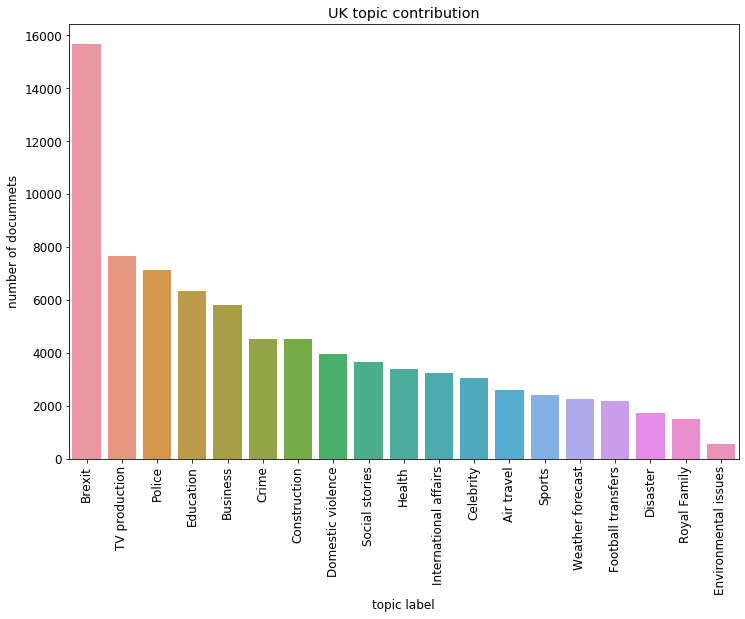

In [527]:
import seaborn 
ax=seaborn.barplot(x=empt, y=final['topic'].value_counts())
ax.set_title('UK topic contribution')
ax.set_ylabel('number of documnets')
ax.set_xlabel('topic label')
plt.xticks(rotation=90)

## User profile vector creation 

In this part, we will be creating user profile vectors based on the datasets used in the training. 

In [568]:
user_profile =final[["panelist_id","topic_distribution","combined"]]
user_profile =pd.concat([user_profile.drop(['topic_distribution'], axis=1), user_profile['topic_distribution'].apply(pd.Series)], axis=1)
user_profile = user_profile.groupby(["panelist_id"]).sum()
user_profile['Max'] = user_profile[[x for x in range(19)]].idxmax(axis=1)
user_profile = user_profile.reset_index()

In [569]:
#number of panelists and the number of articles they read
panelist_occurence = pd.DataFrame(data.panelist_id.value_counts(),columns=['panelist_id'])

In [570]:
panelist_occurence.columns = ['occurence']
panelist_occurence["panelist_id"]=panelist_occurence.index
panelist_occurence

occurence       panelist_id
a039264254276179       3181  a039264254276179
3cca9a0b1908da80       2712  3cca9a0b1908da80
0186afc39055590a       2445  0186afc39055590a
cd36f689f65231b0       1765  cd36f689f65231b0
f1749631b8687508       1474  f1749631b8687508
b503ba00dac1956c       1374  b503ba00dac1956c
c5742ca8a0379047       1206  c5742ca8a0379047
2fba1002df39d4af       1201  2fba1002df39d4af
23961d16bc55402c       1116  23961d16bc55402c
ba27c45c288269f5       1104  ba27c45c288269f5
d0093ff10a8981dd       1103  d0093ff10a8981dd
6c2b0bd91af8295d       1082  6c2b0bd91af8295d
b868d7c531c4dca0       1032  b868d7c531c4dca0
d432fd73db4d32cb        960  d432fd73db4d32cb
caa901614f039f20        941  caa901614f039f20
f029a80b79d2fa83        935  f029a80b79d2fa83
0449943bb9b92714        895  0449943bb9b92714
4dbf8d89d10604aa        879  4dbf8d89d10604aa
26f950878fb1d4cb        860  26f950878fb1d4cb
233d06fcc4fa3615        854  233d06fcc4fa3615
20169bd8a6896b8c        846  20169bd8a6896b8c
593233b7f69b15f0        842  593233b7f69b15f0
133827c533b78649        837  133827c533b78649
419c7b1baa178cd9        832  419c7b1baa178cd9
cdfb62699c91c741        824  cdfb62699c91c741
789ba70b0dcc9fa6        800  789ba70b0dcc9fa6
15015c0a158a708a        773  15015c0a158a708a
dd89d8a456ff4ca7        771  dd89d8a456ff4ca7
f311895640f3871a        758  f311895640f3871a
df9d16115f34f16f        725  df9d16115f34f16f
f6a1d1741aa596f3        711  f6a1d1741aa596f3
d78c84d2629868db        691  d78c84d2629868db
41a7c30d2227d1d4        689  41a7c30d2227d1d4
d57b30f5c364302f        661  d57b30f5c364302f
60d39bd3366df363        614  60d39bd3366df363
468d62c71096cdb5        614  468d62c71096cdb5
bcd353af9c257844        611  bcd353af9c257844
ac30a7b66450041f        609  ac30a7b66450041f
2fc17a6fc495c473        597  2fc17a6fc495c473
f9d2c2d40c429064        589  f9d2c2d40c429064
8478a7a02123db2d        561  8478a7a02123db2d
574a2a0674067829        561  574a2a0674067829
74a34b40a01fa8f5        547  74a34b40a01fa8f5
5d7c01791304af11        535  5d7c01791304af11
8746059c24a48b95        533  8746059c24a48b95
3dccb56457075df4        526  3dccb56457075df4
1d536d48a445a988        503  1d536d48a445a988
cf25b06208c531fa        500  cf25b06208c531fa
5bca336f3d4f4398        496  5bca336f3d4f4398
7bb44811273cb90c        495  7bb44811273cb90c
d4d91fab9f03470d        481  d4d91fab9f03470d
61c98bb7631996d0        474  61c98bb7631996d0
48b8fafa94ba879f        445  48b8fafa94ba879f
800556cafb099fc9        443  800556cafb099fc9
25b6d6386b780660        441  25b6d6386b780660
9c837ff2933c199b        434  9c837ff2933c199b
88ff14b45a8d0547        434  88ff14b45a8d0547
4980b0c665f00600        424  4980b0c665f00600
52b69f3f7a591dbf        412  52b69f3f7a591dbf
ba89b35c46b1864a        410  ba89b35c46b1864a
acfd977a607674f7        405  acfd977a607674f7
c922a6f2a4782396        391  c922a6f2a4782396
a6168b9654790f5b        388  a6168b9654790f5b
2240c27ba8fd4b62        387  2240c27ba8fd4b62
6a43965ab55f2ac2        375  6a43965ab55f2ac2
054c02429f1fa008        372  054c02429f1fa008
8dc1b8b230c6468b        364  8dc1b8b230c6468b
1b2d20d6cdc08d70        363  1b2d20d6cdc08d70
98d790759ac21101        361  98d790759ac21101
7c546b9980541900        345  7c546b9980541900
7c693bb3834c1983        333  7c693bb3834c1983
d85146dcc8d8dc0f        319  d85146dcc8d8dc0f
328d3f76821b004a        315  328d3f76821b004a
ba7373a7c335bc05        301  ba7373a7c335bc05
bb017f094829f756        288  bb017f094829f756
cf2d2045f6c78925        285  cf2d2045f6c78925
c94831b19da2999b        283  c94831b19da2999b
1cc63bbc958a450f        281  1cc63bbc958a450f
4f9580a1c3bba238        274  4f9580a1c3bba238
41c01660f481d610        273  41c01660f481d610
925a9b1dcc406635        267  925a9b1dcc406635
1dda9055c81c88b5        266  1dda9055c81c88b5
afcc4faf82aa2919        266  afcc4faf82aa2919
c80f19fc385d3387        260  c80f19fc385d3387
b8cc461ddd71c527        256  b8cc461ddd71c527
48bf370b9c615c6a        251  48bf370b9c615c6a
c289516a6c855771

In [571]:
#combine the panelist_occurence list with 
user_profile = pd.concat([user_profile.set_index('panelist_id'),panelist_occurence.set_index('panelist_id')], axis=1, join='inner')

In [572]:
#Normalizing on the number of reads from each panelist
lst =[x for x in range(19)]
user_profile[lst]=user_profile[lst].div(user_profile.occurence, axis=0)
user_profile

0         1         2         3         4         5  \
panelist_id                                                                    
0020d66d597488d4  0.068182  0.022727  0.000000  0.034091  0.090909  0.068182   
004ba38a6a236366  0.333333  0.000000  0.000000  0.666667  0.000000  0.000000   
0098bc8376b41b3a  0.000000  0.000000  0.333333  0.000000  0.000000  0.000000   
011056bd627308a4  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
014b6d6c2f6549c8  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
0161b08045b7b093  0.500000  0.000000  0.000000  0.000000  0.000000  0.000000   
0186afc39055590a  0.211861  0.033538  0.042945  0.015951  0.072802  0.002863   
027babcc36ad1952  1.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
02adbbb616d79957  0.060606  0.030303  0.075758  0.015152  0.045455  0.000000   
02f500f2bba62baf  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
0340dab53179162f  0.283019  0.028302  0.004717  0.066038  0.028302  0.056604   
0350475119df014c  0.021739  0.021739  0.065217  0.000000  0.065217  0.021739   
0367b6d391a251a9  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
0371792f609666c2  0.250000  0.000000  0.000000  0.000000  0.000000  0.000000   
037ab70c1d70b72f  0.000000  0.000000  0.000000  0.500000  0.000000  0.000000   
0384a6f50d937087  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
03aafd14ff45a025  1.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
03ad4d5c9f240b5c  0.000000  0.000000  1.000000  0.000000  0.000000  0.000000   
03adf8a30939649c  0.000000  0.000000  0.000000  0.000000  0.339286  0.000000   
03da686a16f7a66d  0.148325  0.014354  0.009569  0.004785  0.033493  0.004785   
041f1081f50f3720  0.090000  0.035000  0.045000  0.000000  0.060000  0.000000   
043dd71ffaff8b18  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
0449943bb9b92714  0.015642  0.004469  0.000000  0.021229  0.014525  0.532961   
048f3279a17bc645  0.600000  0.000000  0.000000  0.000000  0.000000  0.000000   
054c02429f1fa008  0.212366  0.053763  0.051075  0.016129  0.034946  0.008065   
054c999b11a92d93  0.061947  0.057522  0.084071  0.013274  0.075221  0.097345   
05571d0076335a3b  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
05ab4a58d0f61c3d  0.461538  0.000000  0.000000  0.000000  0.000000  0.000000   
05c4abd28b6b8bf7  0.019608  0.000000  0.019608  0.000000  0.019608  0.196078   
06739389abc6b46a  0.166667  0.000000  0.000000  0.166667  0.000000  0.000000   
068d5abfc582b827  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
06b690f849a70851  0.000000  0.000000  0.000000  0.000000  1.000000  0.000000   
06d817d47265ad50  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
080c9fccf052a430  0.000000  0.000000  0.000000  0.000000  0.000000  0.083333   
084d0d9aa7619b83  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
08a178a1a1f2af92  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
08cab98038ab98fc  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
091a4a5894441214  0.112426  0.011834  0.082840  0.000000  0.011834  0.011834   
0963532fa1fbbdd9  0.171053  0.013158  0.013158  0.039474  0.065789  0.039474   
09a80a87fd7a0ca9  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
09fb94dffbfba006  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
0a1c0c0b7fd401a4  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
0b257cd747665f2c  0.000000  0.000000  0.166667  0.166667  0.000000  0.000000   
0b442fa493d3354f  0.428571  0.035714  0.000000  0.000000  0.000000  0.000000   
0b53f909f1d504d7  0.078212  0.078212  0.011173  0.134078  0.044693  0.067039   
0b700c500c212791  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
0bc65bbc7a8990d0  0.000000  0.045455  0.000000  0.000000  0.045455  0.181818   
0c713d90c6c83cf4  0.167568  0.048649  0.032432  0.005405  0.027027  0.000000   
0c80837c17c9af51  0.00000

In [573]:
survey = pd.read_csv("/home/meftahzi/uk/survey/pypaneldata.csv", sep=';')
survey = survey[['panelist_id',"issueseufirstW1"]]

/home/meftahzi/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (10,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,90,91,127,128,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,169,170,172,173,174,178,179,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,244,263,266,270,273,274,305,306,307,308,309,312,313,322,323,324,325,326,327,381,382,383,384,385,386,387,388,389,390,391,392,395,396,397,398,426,428,429,430,437,438,439,440,441,442,443,444,445,446,447,448,449,450,484,485,486,493,494,495,496,497,499,500,515,516,523,524,525,526,527,528,581,582,583,584,585,586,587,588,589,590,591,592,601,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624,625,626,627,628,629,630,631,632,633,634,635,636,637,638,639,640,641,642,643,644,645,646,647,648,700,702,703,704,705,707,722,723,724,725,726,727,

In [574]:
topic_labels

{0: 'Brexit',
 1: 'Air travel',
 2: 'International affairs',
 3: 'Royal Family',
 4: 'Crime',
 5: 'Celebrity',
 6: 'Police',
 7: 'Education',
 8: 'Social stories',
 9: 'Sports',
 10: 'Disaster',
 11: 'Construction',
 12: 'Business',
 13: 'Football transfers',
 14: 'Health',
 15: 'Domestic violence',
 16: 'Environmental issues',
 17: 'Weather forecast',
 18: 'TV production',
 'Max': 'Max',
 'occurence': 'occurrence'}

In [575]:
topic_labels.update({"Max": "Max" , "occurence": "occurrence"})

In [577]:
#Below is the final dataframe that each panelist activity is a weighted sum of all the topics 
user_profile.columns = user_profile.columns.to_series().map(topic_labels)
user_profile = user_profile.reset_index() 
user_profile = pd.concat([user_profile.set_index('panelist_id'),survey.set_index('panelist_id')], axis=1, join='inner')
user_profile['Max']= user_profile['Max'].apply(lambda x :  topic_labels[x])
user_profile

Brexit  Air travel  International affairs  Royal Family  \
panelist_id                                                                   
0020d66d597488d4  0.068182    0.022727               0.000000      0.034091   
004ba38a6a236366  0.333333    0.000000               0.000000      0.666667   
0098bc8376b41b3a  0.000000    0.000000               0.333333      0.000000   
011056bd627308a4  0.000000    0.000000               0.000000      0.000000   
014b6d6c2f6549c8  0.000000    0.000000               0.000000      0.000000   
0161b08045b7b093  0.500000    0.000000               0.000000      0.000000   
0186afc39055590a  0.211861    0.033538               0.042945      0.015951   
027babcc36ad1952  1.000000    0.000000               0.000000      0.000000   
02adbbb616d79957  0.060606    0.030303               0.075758      0.015152   
02f500f2bba62baf  0.000000    0.000000               0.000000      0.000000   
0340dab53179162f  0.283019    0.028302               0.004717      0.066038   
0350475119df014c  0.021739    0.021739               0.065217      0.000000   
0367b6d391a251a9  0.000000    0.000000               0.000000      0.000000   
0371792f609666c2  0.250000    0.000000               0.000000      0.000000   
037ab70c1d70b72f  0.000000    0.000000               0.000000      0.500000   
0384a6f50d937087  0.000000    0.000000               0.000000      0.000000   
03aafd14ff45a025  1.000000    0.000000               0.000000      0.000000   
03ad4d5c9f240b5c  0.000000    0.000000               1.000000      0.000000   
03adf8a30939649c  0.000000    0.000000               0.000000      0.000000   
03da686a16f7a66d  0.148325    0.014354               0.009569      0.004785   
041f1081f50f3720  0.090000    0.035000               0.045000      0.000000   
043dd71ffaff8b18  0.000000    0.000000               0.000000      0.000000   
0449943bb9b92714  0.015642    0.004469               0.000000      0.021229   
048f3279a17bc645  0.600000    0.000000               0.000000      0.000000   
054c02429f1fa008  0.212366    0.053763               0.051075      0.016129   
054c999b11a92d93  0.061947    0.057522               0.084071      0.013274   
05571d0076335a3b  0.000000    0.000000               0.000000      0.000000   
05ab4a58d0f61c3d  0.461538    0.000000               0.000000      0.000000   
05c4abd28b6b8bf7  0.019608    0.000000               0.019608      0.000000   
06739389abc6b46a  0.166667    0.000000               0.000000      0.166667   
068d5abfc582b827  0.000000    0.000000               0.000000      0.000000   
06b690f849a70851  0.000000    0.000000               0.000000      0.000000   
06d817d47265ad50  0.000000    0.000000               0.000000      0.000000   
080c9fccf052a430  0.000000    0.000000               0.000000      0.000000   
084d0d9aa7619b83  0.000000    0.000000               0.000000      0.000000   
08a178a1a1f2af92  0.000000    0.000000               0.000000      0.000000   
08cab98038ab98fc  0.000000    0.000000               0.000000      0.000000   
091a4a5894441214  0.112426    0.011834               0.082840      0.000000   
0963532fa1fbbdd9  0.171053    0.013158               0.013158      0.039474   
09a80a87fd7a0ca9  0.000000    0.000000               0.000000      0.000000   
09fb94dffbfba006  0.000000    0.000000               0.000000      0.000000   
0a1c0c0b7fd401a4  0.000000    0.000000               0.000000      0.000000   
0b257cd747665f2c  0.000000    0.000000               0.166667      0.166667   
0b442fa493d3354f  0.428571    0.035714               0.000000      0.000000   
0b53f909f1d504d7  0.078212    0.078212               0.011173      0.134078   
0b700c500c212791  0.000000    0.000000               0.000000      0.000000   
0bc65bbc7a8990d0  0.000000    0.045455               0.000000      0.000000   
0c713d90c6c83cf4  0.167568    0.048649               0.032432      0.005405   
0c80837c17c9af51  0.000000    0.000000               0.000000      0.0

### Topic/issue aggregation 

In [579]:
aggreg = user_profile[["Max","occurrence","issueseufirstW1"]]
aggreg

Max  occurrence  \
panelist_id                                           
0020d66d597488d4          TV production          88   
004ba38a6a236366           Royal Family           3   
0098bc8376b41b3a  International affairs           3   
011056bd627308a4         Social stories           3   
014b6d6c2f6549c8          TV production           1   
0161b08045b7b093                 Brexit           2   
0186afc39055590a                 Brexit        2445   
027babcc36ad1952                 Brexit           3   
02adbbb616d79957                 Police          66   
02f500f2bba62baf      Domestic violence           1   
0340dab53179162f                 Brexit         212   
0350475119df014c     Football transfers          46   
0367b6d391a251a9                 Police           6   
0371792f609666c2                 Brexit           8   
037ab70c1d70b72f           Royal Family           2   
0384a6f50d937087      Domestic violence           2   
03aafd14ff45a025                 Brexit           2   
03ad4d5c9f240b5c  International affairs           1   
03adf8a30939649c                  Crime          56   
03da686a16f7a66d               Business         209   
041f1081f50f3720       Weather forecast         200   
043dd71ffaff8b18          TV production           1   
0449943bb9b92714              Celebrity         895   
048f3279a17bc645                 Brexit           5   
054c02429f1fa008                 Brexit         372   
054c999b11a92d93               Business         226   
05571d0076335a3b               Disaster          14   
05ab4a58d0f61c3d                 Brexit          13   
05c4abd28b6b8bf7          TV production          51   
06739389abc6b46a               Disaster           6   
068d5abfc582b827          TV production           3   
06b690f849a70851                  Crime           5   
06d817d47265ad50                 Health           2   
080c9fccf052a430               Business          12   
084d0d9aa7619b83               Business           3   
08a178a1a1f2af92               Business           8   
08cab98038ab98fc               Business           2   
091a4a5894441214              Education         169   
0963532fa1fbbdd9                 Police          76   
09a80a87fd7a0ca9          TV production           1   
09fb94dffbfba006                 Police           4   
0a1c0c0b7fd401a4          TV production           8   
0b257cd747665f2c               Business           6   
0b442fa493d3354f                 Brexit          28   
0b53f909f1d504d7                 Police         179   
0b700c500c212791                 Police           8   
0bc65bbc7a8990d0      Domestic violence          22   
0c713d90c6c83cf4                 Brexit         185   
0c80837c17c9af51              Education           5   
0ccff3530d83836d                 Brexit          97   
0d7612bdda906f8d                 Health           9   
0f31493c52197417     Football transfers           3   
0f55a30198a77602     Football transfers          91   
0ff81165d124aba1      Domestic violence          17   
1063cc32dd05d887          TV production         101   
10b91f5ab4b1417c          TV production           4   
10cb994263d4002d                 Brexit          27   
11689ddb64f97f08          TV production           8   
11d735015cdb0a9c                 Police           2   
124cf0a6009aa4f7                 Police          25   
1268c69812553d16                 Sports          12   
13153aa9133d411d              Education          11   
133827c533b78649                 Brexit         837   
13667cb87bc0fa24              Education         192   
1372a3947718f24b                 Brexit           6   
14b7dc427fd09d34  International affairs           8   
15015c0a158a708a                 Brexit         773   
15261bd4847779a3         Social stories           3   
1568bf4164712c03                 Sports          29   
15a054265a4761d3          TV production          84   
15bd02a141188f42                 Brexit          56   
16026875ff787745     

In [589]:
aggreg["issueseufirstW1"].value_counts()

The decision of the United Kingdom to leave the European Union (Brexit)    411
Health and social security                                                  56
The environment, climate and energy issues                                  51
Immigration                                                                 47
Crime                                                                       38
Rising prices / inflation / cost of living                                  33
Housing                                                                     27
Economic situation                                                          27
Don't know                                                                  27
Terrorism                                                                   20
Other                                                                       20
The education system                                                         8
Government debt                                     

The number of participants in this case is 411


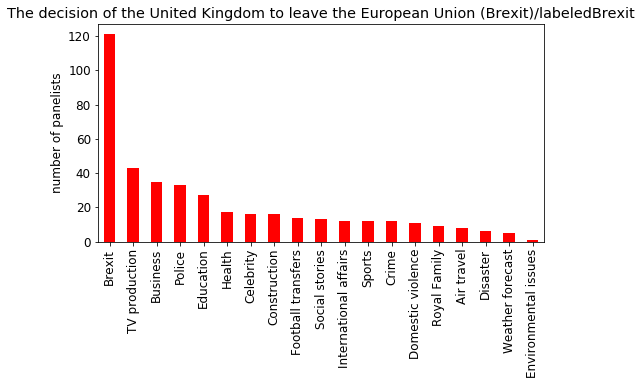

In [590]:
aggreg[(aggreg['issueseufirstW1'] =="The decision of the United Kingdom to leave the European Union (Brexit)")]["Max"].value_counts().plot(kind='bar',figsize=(8, 4),color='r')
plt.title("The decision of the United Kingdom to leave the European Union (Brexit)/labeledBrexit")
plt.ylabel("number of panelists")
print("The number of participants in this case is "+str(len(aggreg[(aggreg['issueseufirstW1'] =="The decision of the United Kingdom to leave the European Union (Brexit)")]["Max"])))

The number of participants in this case is 198


Text(0, 0.5, 'number of panelists')

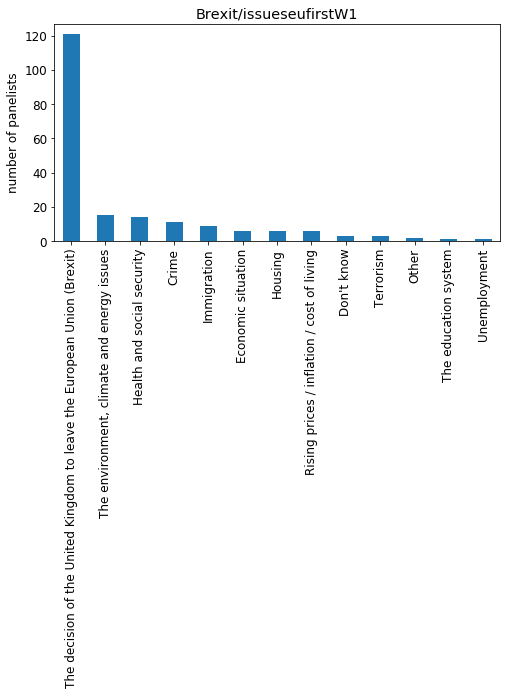

In [595]:
print("The number of participants in this case is "+str(len(aggreg[(aggreg['Max'] =="Brexit")]["issueseufirstW1"])))
aggreg[(aggreg['Max'] =="Brexit")]["issueseufirstW1"].value_counts().plot(kind='bar',figsize=(8, 4))
plt.title("Brexit/issueseufirstW1")
plt.ylabel("number of panelists")